In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 191 (delta 40), reused 170 (delta 32), pack-reused 0
Receiving objects: 100% (191/191), 10.84 MiB | 3.18 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [2]:
!pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 21.7 MB/s eta 0:00:00


In [3]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorization_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorization_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorization_Cython_Epoch.c: In function ‘__pyx_pf_32MatrixFactorization

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import scipy.sparse as sps

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hyperparameters-tuning/best_params_knn_item.json
/kaggle/input/hyperparameters-tuning/__results__.html
/kaggle/input/hyperparameters-tuning/pure_svd_params.json
/kaggle/input/hyperparameters-tuning/submission.csv
/kaggle/input/hyperparameters-tuning/__notebook__.ipynb
/kaggle/input/hyperparameters-tuning/__output__.json
/kaggle/input/hyperparameters-tuning/best_params_knn_user.json
/kaggle/input/hyperparameters-tuning/custom.css
/kaggle/input/hyperparameters-tuning/RecSys_Course_AT_PoliMi/run_all_algorithms.py
/kaggle/input/hyperparameters-tuning/RecSys_Course_AT_PoliMi/Practice extra - Cython for KNN similarity.ipynb
/kaggle/input/hyperparameters-tuning/RecSys_Course_AT_PoliMi/Practice extra 5 - Implicit feedback recommender.ipynb
/kaggle/input/hyperparameters-tuning/RecSys_Course_AT_PoliMi/Practice 04 - Collaborative Filtering.ipynb
/kaggle/input/hyperparameters-tuning/RecSys_Course_AT_PoliMi/Practice 02 - How to build a recommender.ipynb
/kaggle/input/hyperparameters-t

# Configurations

In [5]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [6]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [7]:
from os import system, getpid, walk
from psutil import Process
from colorama import Fore, Style, init
from IPython.display import display, HTML

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)
    
def GetMemUsage():   
    pid = getpid()
    py = Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return f"RAM memory GB usage = {memory_use :.4}"

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.1957


In [8]:
config = {
    'tune_parameters_item_knn': True,
    'tune_parameters_user_knn': True,
    'tune_parameters_pure_svd': False,
    'database_path': '/kaggle/working/tuning.db',
    'copy_prev_tuning_db': False,
    'copy_prev_best_params': True,
    'train_best_models': True,
    'copy_prev_best_models': False,
    'submit': False,
    'save_github': True
}

In [9]:
try:
    shutil.copyfile(
        '/kaggle/working/RecSys_Challenge_2023/tuning_results/tuning.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass # if not present optuna will create it

# Data Import

In [10]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [11]:
train_data.head(5)

,row,col,data
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0


In [12]:
user_ids_test.head(5)

,user_id
0,1
1,2
2,3
3,4
4,5


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478730 entries, 0 to 478729
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   row     478730 non-null  int64  
 1   col     478730 non-null  int64  
 2   data    478730 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 11.0 MB


In [14]:
train_data.describe()

,row,col,data
count,478730.000000,478730.000000,478730.0
mean,6477.521302,4101.952798,1.0
std,3738.435208,5388.639634,0.0
min,1.000000,1.000000,1.0
25%,3204.000000,315.000000,1.0
50%,6493.000000,1575.000000,1.0
75%,9715.000000,5879.000000,1.0
max,13024.000000,22347.000000,1.0


In [15]:
n_users_train = train_data.row.max()
n_users_test = len(user_ids_test.user_id.unique())

print(f'Train number of users: {n_users_train}')
print(f'Test number of users: {n_users_test}')

Train number of users: 13024
Test number of users: 10882


In [16]:
number_of_items = train_data.col.max()

print(f'Number of items: {number_of_items}')

Number of items: 22347


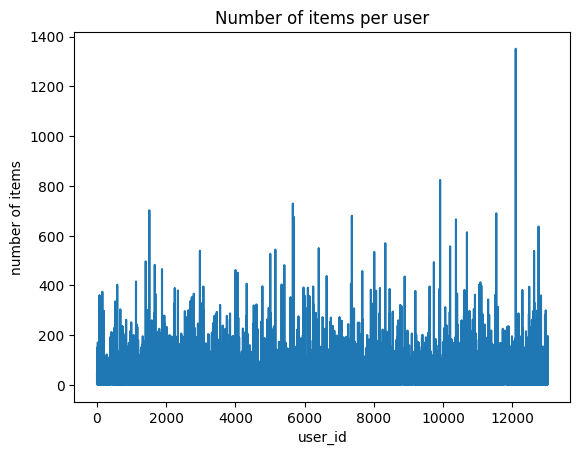

In [17]:
train_data.groupby('row').count().col.plot()
plt.xlabel('user_id')
plt.ylabel('number of items')
plt.title('Number of items per user');

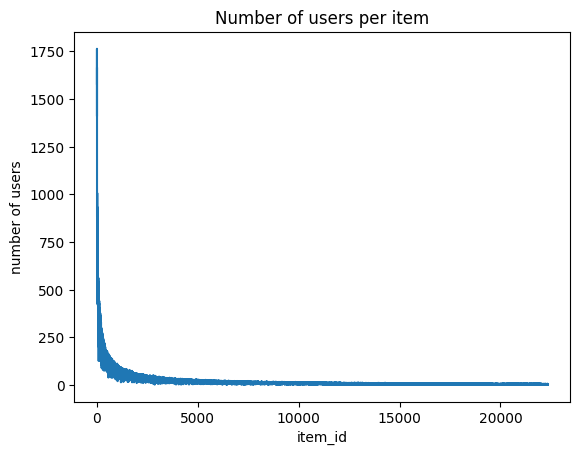

In [18]:
train_data.groupby('col').count().row.plot()
plt.xlabel('item_id')
plt.ylabel('number of users')
plt.title('Number of users per item');

In [19]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

# Cross Validation Split

In [20]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [21]:
from Data_manager.IncrementalSparseMatrix import IncrementalSparseMatrix


class CrossValidationSplitter:
    def __init__(self, n_splits):
        self.n_splits = n_splits
        self.folds = []
        
    def split(self, URM):
        n_int_per_split = int(URM.nnz / self.n_splits)
        indices = np.arange(0, URM.nnz, 1)
        np.random.shuffle(indices)
        num_users, num_items = URM.shape
        
        URM_all = sps.coo_matrix(URM)
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                indices_valid = indices[n_int_per_split * i:]
                indices_train = indices[:n_int_per_split * i]
            else:
                indices_valid = indices[n_int_per_split * i: n_int_per_split * (i + 1)]
                indices_train_1 = indices[n_int_per_split * max(0, i - 1): n_int_per_split * i]
                indices_train_2 = indices[n_int_per_split * (i + 1):]
                indices_train = np.concatenate((indices_train_1, indices_train_2))
                
            URM_valid_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_train_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_valid_builder.add_data_lists(
                URM_all.row[indices_valid],
                URM_all.col[indices_valid],
                URM_all.data[indices_valid]
            )
            
            URM_train_builder.add_data_lists(
                URM_all.row[indices_train],
                URM_all.col[indices_train],
                URM_all.data[indices_train]
            )
            
            yield URM_train_builder.get_SparseMatrix(), URM_valid_builder.get_SparseMatrix()

In [22]:
# next(CrossValidationSplitter(10).split(URM_all))

# Experiments

In [23]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [24]:
URM_train, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_validation, URM_test = split_train_in_two_percentage_global_sample(URM_test_complete, train_percentage = 0.8)

In [25]:
# recommender = MultiThreadSLIM_SLIMElasticNetRecommender(URM_train)
# recommender.fit(l1_ratio=0.5, alpha=1, positive_only=True, topK=10)

# np.bool = bool
# np.float = float
# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [26]:
# evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
# early_stopping_params = {
#     'epochs_min': 30,
#     'stop_on_validation': True,
#     'validation_every_n': 1,
#     'validation_metric': 'MAP',
#     'lower_validations_allowed': 5,
#     'evaluator_object': evaluator_validation
# }

# recommender = IALSRecommender(URM_train)
# recommender.fit(reg=1e-2, **early_stopping_params)

In [27]:
# evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [28]:
# recommender = PureSVDRecommender(URM_train)
# recommender.fit(num_factors=100)

# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [29]:
# recommender = ItemKNNCFRecommender(URM_train)
# recommender.fit(topK=10, shrink=100)

# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [30]:
# recommender = UserKNNCFRecommender(URM_train)
# recommender.fit(topK=20, shrink=10)

# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

# Hyperparameters tuning

Not considering adjusted cosine and pearson since they remove the mean of the interactions, but here there are all interactions equal to 1

## Item KNN Collaborative Filtering

In [31]:
import optuna

def objective_item_knn(trial):
    similarity = trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky"])
    topK = trial.suggest_int('topK', 10, 1000)
    shrink = trial.suggest_int('shrink', 0, 500)
    
    map_sum = 0
    for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
        recommender = ItemKNNCFRecommender(URM_train)
        recommender.fit(topK=topK, shrink=shrink, similarity=similarity)

        evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
        result_df, _ = evaluator.evaluateRecommender(recommender)
        print(f'MAP is {result_df.loc[10, "MAP"]}')
        map_sum += result_df.loc[10, 'MAP']
        
    return map_sum / 10

In [32]:
%%time

if config['tune_parameters_item_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_item', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_item_knn, n_trials=75)

[I 2023-11-14 23:39:42,910] A new study created in RDB with name: hyperparameters_tuning_knn_item


ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4545.42 column/sec. Elapsed time 4.92 sec
EvaluatorHoldout: Ignoring 4043 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8981 (100.0%) in 14.95 sec. Users per second: 601
MAP is 0.01948780759380911
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4605.78 column/sec. Elapsed time 4.85 sec
EvaluatorHoldout: Ignoring 3997 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9027 (100.0%) in 15.18 sec. Users per second: 595
MAP is 0.01978718166488186
ItemKNNCFRecommender: URM Detected 597 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
Similarity colum

[I 2023-11-14 23:42:49,190] Trial 0 finished with value: 0.01447340933220671 and parameters: {'similarity': 'dice', 'topK': 234, 'shrink': 421}. Best is trial 0 with value: 0.01447340933220671.


MAP is 0.019644861133181445
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4385.19 column/sec. Elapsed time 5.10 sec
EvaluatorHoldout: Ignoring 4022 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9002 (100.0%) in 16.30 sec. Users per second: 552
MAP is 0.021028065191861997
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4449.72 column/sec. Elapsed time 5.02 sec
EvaluatorHoldout: Ignoring 3951 (30.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9073 (100.0%) in 16.40 sec. Users per second: 553
MAP is 0.02076824399622809
ItemKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 239 ( 1.1%) items with no i

[I 2023-11-14 23:46:08,483] Trial 1 finished with value: 0.015042255678768579 and parameters: {'similarity': 'tanimoto', 'topK': 437, 'shrink': 212}. Best is trial 1 with value: 0.015042255678768579.


MAP is 0.02071896052187203
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4530.98 column/sec. Elapsed time 4.93 sec
EvaluatorHoldout: Ignoring 4016 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9008 (100.0%) in 16.80 sec. Users per second: 536
MAP is 0.01861930929121201
ItemKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4500.36 column/sec. Elapsed time 4.97 sec
EvaluatorHoldout: Ignoring 4001 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9023 (100.0%) in 16.72 sec. Users per second: 540
MAP is 0.018633197525195645
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no in

[I 2023-11-14 23:49:27,456] Trial 2 finished with value: 0.013908321639505446 and parameters: {'similarity': 'jaccard', 'topK': 355, 'shrink': 493}. Best is trial 1 with value: 0.015042255678768579.


MAP is 0.018578421264130736
ItemKNNCFRecommender: URM Detected 473 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4289.13 column/sec. Elapsed time 5.21 sec
EvaluatorHoldout: Ignoring 4037 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8987 (100.0%) in 12.77 sec. Users per second: 703
MAP is 0.02147049265164321
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4247.71 column/sec. Elapsed time 5.26 sec
EvaluatorHoldout: Ignoring 3993 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9031 (100.0%) in 12.87 sec. Users per second: 702
MAP is 0.02062668181730303
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 226 ( 1.0%) items with no in

[I 2023-11-14 23:52:21,645] Trial 3 finished with value: 0.015439467799852714 and parameters: {'similarity': 'tversky', 'topK': 139, 'shrink': 271}. Best is trial 3 with value: 0.015439467799852714.


MAP is 0.02162201059375784
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4495.68 column/sec. Elapsed time 4.97 sec
EvaluatorHoldout: Ignoring 4066 (31.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8958 (100.0%) in 17.07 sec. Users per second: 525
MAP is 0.019032721483324196
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4454.48 column/sec. Elapsed time 5.02 sec
EvaluatorHoldout: Ignoring 4014 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9010 (100.0%) in 17.21 sec. Users per second: 524
MAP is 0.0193953543681623
ItemKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 222 ( 1.0%) items with no int

[I 2023-11-14 23:55:44,640] Trial 4 finished with value: 0.01403070675191274 and parameters: {'similarity': 'dice', 'topK': 453, 'shrink': 363}. Best is trial 3 with value: 0.015439467799852714.


MAP is 0.01965330453715407
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 3817.96 column/sec. Elapsed time 5.85 sec
EvaluatorHoldout: Ignoring 3899 (29.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9125 (100.0%) in 18.40 sec. Users per second: 496
MAP is 0.01653398130028261
ItemKNNCFRecommender: URM Detected 503 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 3888.15 column/sec. Elapsed time 5.75 sec
EvaluatorHoldout: Ignoring 4020 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9004 (100.0%) in 18.11 sec. Users per second: 497
MAP is 0.016434719489750556
ItemKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 220 ( 1.0%) items with no in

[I 2023-11-14 23:59:20,931] Trial 5 finished with value: 0.012051860399449332 and parameters: {'similarity': 'cosine', 'topK': 535, 'shrink': 301}. Best is trial 3 with value: 0.015439467799852714.


MAP is 0.016495919374597816
ItemKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4456.33 column/sec. Elapsed time 5.01 sec
EvaluatorHoldout: Ignoring 4038 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8986 (100.0%) in 16.31 sec. Users per second: 551
MAP is 0.023796037221921987
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4401.85 column/sec. Elapsed time 5.08 sec
EvaluatorHoldout: Ignoring 4015 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9009 (100.0%) in 16.42 sec. Users per second: 549
MAP is 0.023371804562280808
ItemKNNCFRecommender: URM Detected 593 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 232 ( 1.0%) items with no 

[I 2023-11-15 00:02:42,124] Trial 6 finished with value: 0.01599941364751957 and parameters: {'similarity': 'dice', 'topK': 652, 'shrink': 23}. Best is trial 6 with value: 0.01599941364751957.


MAP is 0.023377766908250684
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4036.12 column/sec. Elapsed time 5.54 sec
EvaluatorHoldout: Ignoring 3976 (30.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9048 (100.0%) in 14.65 sec. Users per second: 618
MAP is 0.01937454826463437
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4036.18 column/sec. Elapsed time 5.54 sec
EvaluatorHoldout: Ignoring 4044 (31.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8980 (100.0%) in 14.55 sec. Users per second: 617
MAP is 0.019390497401633212
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no i

[I 2023-11-15 00:05:47,486] Trial 7 finished with value: 0.0142877384827351 and parameters: {'similarity': 'cosine', 'topK': 130, 'shrink': 288}. Best is trial 6 with value: 0.01599941364751957.


MAP is 0.019963874227742904
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4509.57 column/sec. Elapsed time 4.96 sec
EvaluatorHoldout: Ignoring 3987 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9037 (100.0%) in 18.02 sec. Users per second: 502
MAP is 0.018555392205939884
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4484.86 column/sec. Elapsed time 4.98 sec
EvaluatorHoldout: Ignoring 4056 (31.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8968 (100.0%) in 17.96 sec. Users per second: 499
MAP is 0.018603535675346533
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no 

[I 2023-11-15 00:09:15,511] Trial 8 finished with value: 0.013478224155250618 and parameters: {'similarity': 'dice', 'topK': 527, 'shrink': 475}. Best is trial 6 with value: 0.01599941364751957.


MAP is 0.017953741874108045
ItemKNNCFRecommender: URM Detected 510 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4197.41 column/sec. Elapsed time 5.32 sec
EvaluatorHoldout: Ignoring 4032 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8992 (100.0%) in 14.44 sec. Users per second: 623
MAP is 0.020156607460599787
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 193 ( 0.9%) items with no interactions.
Similarity column 22347 (100.0%), 4168.70 column/sec. Elapsed time 5.36 sec
EvaluatorHoldout: Ignoring 3963 (30.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9061 (100.0%) in 14.59 sec. Users per second: 621
MAP is 0.020266518114437734
ItemKNNCFRecommender: URM Detected 628 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no 

[I 2023-11-15 00:12:21,419] Trial 9 finished with value: 0.01490568336731041 and parameters: {'similarity': 'tversky', 'topK': 194, 'shrink': 407}. Best is trial 6 with value: 0.01599941364751957.


MAP is 0.020237737856983958
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 3953.27 column/sec. Elapsed time 5.65 sec
EvaluatorHoldout: Ignoring 4031 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8993 (100.0%) in 17.41 sec. Users per second: 516
MAP is 0.022160957640775223
ItemKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 3897.25 column/sec. Elapsed time 5.73 sec
EvaluatorHoldout: Ignoring 4046 (31.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8978 (100.0%) in 17.46 sec. Users per second: 514
MAP is 0.023001287096854027
ItemKNNCFRecommender: URM Detected 593 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no 

[I 2023-11-15 00:15:54,831] Trial 10 finished with value: 0.014337191712201183 and parameters: {'similarity': 'asymmetric', 'topK': 846, 'shrink': 5}. Best is trial 6 with value: 0.01599941364751957.


MAP is 0.022535986228600955
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4017.73 column/sec. Elapsed time 5.56 sec
EvaluatorHoldout: Ignoring 4044 (31.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8980 (100.0%) in 18.20 sec. Users per second: 493
MAP is 0.02154866192950815
ItemKNNCFRecommender: URM Detected 464 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4049.04 column/sec. Elapsed time 5.52 sec
EvaluatorHoldout: Ignoring 4040 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8984 (100.0%) in 18.10 sec. Users per second: 496
MAP is 0.02191379030092298
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no in

[I 2023-11-15 00:19:32,225] Trial 11 finished with value: 0.015089691535306171 and parameters: {'similarity': 'tversky', 'topK': 734, 'shrink': 132}. Best is trial 6 with value: 0.01599941364751957.


MAP is 0.020993874068657006
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4020.09 column/sec. Elapsed time 5.56 sec
EvaluatorHoldout: Ignoring 4043 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8981 (100.0%) in 18.16 sec. Users per second: 494
MAP is 0.02157092221144107
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4023.77 column/sec. Elapsed time 5.55 sec
EvaluatorHoldout: Ignoring 4022 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9002 (100.0%) in 18.14 sec. Users per second: 496
MAP is 0.021044494521499563
ItemKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no i

[I 2023-11-15 00:23:09,536] Trial 12 finished with value: 0.015005208554230504 and parameters: {'similarity': 'tversky', 'topK': 715, 'shrink': 140}. Best is trial 6 with value: 0.01599941364751957.


MAP is 0.02114501498303917
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4349.34 column/sec. Elapsed time 5.14 sec
EvaluatorHoldout: Ignoring 4022 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9002 (100.0%) in 16.51 sec. Users per second: 545
MAP is 0.024151881592450415
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4341.28 column/sec. Elapsed time 5.15 sec
EvaluatorHoldout: Ignoring 3986 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9038 (100.0%) in 16.40 sec. Users per second: 551
MAP is 0.024549525460401754
ItemKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 226 ( 1.0%) items with no i

[I 2023-11-15 00:26:33,180] Trial 13 finished with value: 0.01586080118852688 and parameters: {'similarity': 'jaccard', 'topK': 690, 'shrink': 10}. Best is trial 6 with value: 0.01599941364751957.


MAP is 0.02354352822718814
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4277.59 column/sec. Elapsed time 5.22 sec
EvaluatorHoldout: Ignoring 4029 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8995 (100.0%) in 18.33 sec. Users per second: 491
MAP is 0.02437542020699329
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4235.49 column/sec. Elapsed time 5.28 sec
EvaluatorHoldout: Ignoring 3979 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9045 (100.0%) in 18.30 sec. Users per second: 494
MAP is 0.023751195521510563
ItemKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no in

[I 2023-11-15 00:30:10,641] Trial 14 finished with value: 0.01573547931903279 and parameters: {'similarity': 'jaccard', 'topK': 999, 'shrink': 7}. Best is trial 6 with value: 0.01599941364751957.


MAP is 0.024222582972582996
ItemKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 185 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4360.63 column/sec. Elapsed time 5.12 sec
EvaluatorHoldout: Ignoring 3979 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9045 (100.0%) in 17.15 sec. Users per second: 527
MAP is 0.02202477910272269
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 157 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4385.77 column/sec. Elapsed time 5.10 sec
EvaluatorHoldout: Ignoring 4009 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9015 (100.0%) in 16.97 sec. Users per second: 531
MAP is 0.022021507364269357
ItemKNNCFRecommender: URM Detected 577 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 266 ( 1.2%) items with no i

[I 2023-11-15 00:33:37,018] Trial 15 finished with value: 0.01562639366135548 and parameters: {'similarity': 'jaccard', 'topK': 648, 'shrink': 80}. Best is trial 6 with value: 0.01599941364751957.


MAP is 0.02215997830994488
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 3914.51 column/sec. Elapsed time 5.71 sec
EvaluatorHoldout: Ignoring 3999 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9025 (100.0%) in 19.51 sec. Users per second: 463
MAP is 0.01930318779404645
ItemKNNCFRecommender: URM Detected 504 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 3913.44 column/sec. Elapsed time 5.71 sec
EvaluatorHoldout: Ignoring 3974 (30.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9050 (100.0%) in 19.49 sec. Users per second: 464
MAP is 0.01898950276243094
ItemKNNCFRecommender: URM Detected 581 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no int

[I 2023-11-15 00:37:21,261] Trial 16 finished with value: 0.013896834908980384 and parameters: {'similarity': 'asymmetric', 'topK': 866, 'shrink': 70}. Best is trial 6 with value: 0.01599941364751957.


MAP is 0.019817981552505658
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4421.82 column/sec. Elapsed time 5.05 sec
EvaluatorHoldout: Ignoring 4012 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9012 (100.0%) in 17.75 sec. Users per second: 508
MAP is 0.021130115753950563
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4394.16 column/sec. Elapsed time 5.09 sec
EvaluatorHoldout: Ignoring 4025 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8999 (100.0%) in 17.68 sec. Users per second: 509
MAP is 0.02115402152267355
ItemKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 246 ( 1.1%) items with no i

[I 2023-11-15 00:40:49,679] Trial 17 finished with value: 0.014886844318546191 and parameters: {'similarity': 'tanimoto', 'topK': 596, 'shrink': 194}. Best is trial 6 with value: 0.01599941364751957.


MAP is 0.020231244206848565
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4366.93 column/sec. Elapsed time 5.12 sec
EvaluatorHoldout: Ignoring 4029 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8995 (100.0%) in 17.89 sec. Users per second: 503
MAP is 0.0221991891438806
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4234.70 column/sec. Elapsed time 5.28 sec
EvaluatorHoldout: Ignoring 4063 (31.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8961 (100.0%) in 17.94 sec. Users per second: 499
MAP is 0.022996144669228055
ItemKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no in

[I 2023-11-15 00:44:22,093] Trial 18 finished with value: 0.01576343602195239 and parameters: {'similarity': 'jaccard', 'topK': 829, 'shrink': 62}. Best is trial 6 with value: 0.01599941364751957.


MAP is 0.023139183321907626
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4552.57 column/sec. Elapsed time 4.91 sec
EvaluatorHoldout: Ignoring 3998 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9026 (100.0%) in 14.50 sec. Users per second: 622
MAP is 0.021410286509167483
ItemKNNCFRecommender: URM Detected 499 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4585.56 column/sec. Elapsed time 4.87 sec
EvaluatorHoldout: Ignoring 4027 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8997 (100.0%) in 14.48 sec. Users per second: 621
MAP is 0.021306140847654618
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 244 ( 1.1%) items with no 

[I 2023-11-15 00:47:27,086] Trial 19 finished with value: 0.015574981731763337 and parameters: {'similarity': 'dice', 'topK': 316, 'shrink': 130}. Best is trial 6 with value: 0.01599941364751957.


MAP is 0.022416927753386183
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4307.28 column/sec. Elapsed time 5.19 sec
EvaluatorHoldout: Ignoring 3990 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9034 (100.0%) in 18.64 sec. Users per second: 485
MAP is 0.02249607303625458
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4317.77 column/sec. Elapsed time 5.18 sec
EvaluatorHoldout: Ignoring 3934 (30.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9090 (100.0%) in 18.73 sec. Users per second: 485
MAP is 0.02264251663261561
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no in

[I 2023-11-15 00:51:04,755] Trial 20 finished with value: 0.01578548685238224 and parameters: {'similarity': 'jaccard', 'topK': 979, 'shrink': 56}. Best is trial 6 with value: 0.01599941364751957.


MAP is 0.023016181383743468
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4320.37 column/sec. Elapsed time 5.17 sec
EvaluatorHoldout: Ignoring 4007 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9017 (100.0%) in 18.18 sec. Users per second: 496
MAP is 0.023813867456708677
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 183 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4318.95 column/sec. Elapsed time 5.17 sec
EvaluatorHoldout: Ignoring 4059 (31.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8965 (100.0%) in 18.06 sec. Users per second: 496
MAP is 0.022919873582450286
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 245 ( 1.1%) items with no 

[I 2023-11-15 00:54:40,098] Trial 21 finished with value: 0.01593295266383083 and parameters: {'similarity': 'jaccard', 'topK': 948, 'shrink': 32}. Best is trial 6 with value: 0.01599941364751957.


MAP is 0.023183171941033545
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4373.14 column/sec. Elapsed time 5.11 sec
EvaluatorHoldout: Ignoring 4030 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8994 (100.0%) in 16.44 sec. Users per second: 547
MAP is 0.02352113048910913
ItemKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4293.61 column/sec. Elapsed time 5.20 sec
EvaluatorHoldout: Ignoring 3992 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9032 (100.0%) in 16.49 sec. Users per second: 548
MAP is 0.023576059372671352
ItemKNNCFRecommender: URM Detected 575 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 256 ( 1.1%) items with no i

[I 2023-11-15 00:58:04,128] Trial 22 finished with value: 0.014316950587965463 and parameters: {'similarity': 'jaccard', 'topK': 725, 'shrink': 0}. Best is trial 6 with value: 0.01599941364751957.


MAP is 0.023624206569298038
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4232.28 column/sec. Elapsed time 5.28 sec
EvaluatorHoldout: Ignoring 4011 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9013 (100.0%) in 18.75 sec. Users per second: 481
MAP is 0.021800402064742392
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4346.24 column/sec. Elapsed time 5.14 sec
EvaluatorHoldout: Ignoring 4033 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8991 (100.0%) in 18.77 sec. Users per second: 479
MAP is 0.021164281565516103
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 228 ( 1.0%) items with no 

[I 2023-11-15 01:01:42,801] Trial 23 finished with value: 0.015244491992710746 and parameters: {'similarity': 'jaccard', 'topK': 923, 'shrink': 106}. Best is trial 6 with value: 0.01599941364751957.


MAP is 0.021821703181972827
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4418.60 column/sec. Elapsed time 5.06 sec
EvaluatorHoldout: Ignoring 4014 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9010 (100.0%) in 17.35 sec. Users per second: 519
MAP is 0.022135867554568946
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4432.14 column/sec. Elapsed time 5.04 sec
EvaluatorHoldout: Ignoring 4015 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9009 (100.0%) in 17.37 sec. Users per second: 519
MAP is 0.02359637716780571
ItemKNNCFRecommender: URM Detected 622 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 246 ( 1.1%) items with no i

[I 2023-11-15 01:05:10,607] Trial 24 finished with value: 0.015787486293789343 and parameters: {'similarity': 'dice', 'topK': 786, 'shrink': 36}. Best is trial 6 with value: 0.01599941364751957.


MAP is 0.023125299693851218
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4394.95 column/sec. Elapsed time 5.08 sec
EvaluatorHoldout: Ignoring 4056 (31.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8968 (100.0%) in 17.68 sec. Users per second: 507
MAP is 0.021290580795208316
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4325.97 column/sec. Elapsed time 5.17 sec
EvaluatorHoldout: Ignoring 4049 (31.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8975 (100.0%) in 17.68 sec. Users per second: 508
MAP is 0.020792032541893213
ItemKNNCFRecommender: URM Detected 599 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 253 ( 1.1%) items with no 

[I 2023-11-15 01:08:39,825] Trial 25 finished with value: 0.01504003519065852 and parameters: {'similarity': 'jaccard', 'topK': 608, 'shrink': 180}. Best is trial 6 with value: 0.01599941364751957.


MAP is 0.02091473307669318
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4418.83 column/sec. Elapsed time 5.06 sec
EvaluatorHoldout: Ignoring 3996 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9028 (100.0%) in 17.42 sec. Users per second: 518
MAP is 0.02211627318184695
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4269.77 column/sec. Elapsed time 5.23 sec
EvaluatorHoldout: Ignoring 4089 (31.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8935 (100.0%) in 17.47 sec. Users per second: 511
MAP is 0.021945523667403825
ItemKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no in

[I 2023-11-15 01:12:08,480] Trial 26 finished with value: 0.015543794186162474 and parameters: {'similarity': 'tanimoto', 'topK': 677, 'shrink': 98}. Best is trial 6 with value: 0.01599941364751957.


MAP is 0.02118932145403709
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4100.56 column/sec. Elapsed time 5.45 sec
EvaluatorHoldout: Ignoring 4016 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9008 (100.0%) in 10.81 sec. Users per second: 834
MAP is 0.025484785129267787
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4118.39 column/sec. Elapsed time 5.43 sec
EvaluatorHoldout: Ignoring 4002 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9022 (100.0%) in 10.48 sec. Users per second: 861
MAP is 0.024604850400959905
ItemKNNCFRecommender: URM Detected 611 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no i

[I 2023-11-15 01:14:45,768] Trial 27 finished with value: 0.017186574971507742 and parameters: {'similarity': 'cosine', 'topK': 38, 'shrink': 29}. Best is trial 27 with value: 0.017186574971507742.


MAP is 0.024829991320134994
ItemKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 3973.89 column/sec. Elapsed time 5.62 sec
EvaluatorHoldout: Ignoring 4096 (31.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8928 (100.0%) in 16.60 sec. Users per second: 538
MAP is 0.018258132964954182
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4010.61 column/sec. Elapsed time 5.57 sec
EvaluatorHoldout: Ignoring 3983 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9041 (100.0%) in 16.83 sec. Users per second: 537
MAP is 0.018915272225470136
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no 

[I 2023-11-15 01:18:08,352] Trial 28 finished with value: 0.013818178740902017 and parameters: {'similarity': 'cosine', 'topK': 312, 'shrink': 161}. Best is trial 27 with value: 0.017186574971507742.


MAP is 0.01894805154520388
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 3969.01 column/sec. Elapsed time 5.63 sec
EvaluatorHoldout: Ignoring 4014 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9010 (100.0%) in 15.84 sec. Users per second: 569
MAP is 0.0180060602857494
ItemKNNCFRecommender: URM Detected 504 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 3953.88 column/sec. Elapsed time 5.65 sec
EvaluatorHoldout: Ignoring 3990 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9034 (100.0%) in 15.80 sec. Users per second: 572
MAP is 0.01855052869055519
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no inte

[I 2023-11-15 01:21:25,147] Trial 29 finished with value: 0.013509612557581235 and parameters: {'similarity': 'cosine', 'topK': 240, 'shrink': 236}. Best is trial 27 with value: 0.017186574971507742.


MAP is 0.0186916942258114
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4083.80 column/sec. Elapsed time 5.47 sec
EvaluatorHoldout: Ignoring 4009 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9015 (100.0%) in 9.99 sec. Users per second: 902
MAP is 0.02478319643627467
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4081.34 column/sec. Elapsed time 5.48 sec
EvaluatorHoldout: Ignoring 4013 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9011 (100.0%) in 10.04 sec. Users per second: 898
MAP is 0.024753889866530012
ItemKNNCFRecommender: URM Detected 603 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 235 ( 1.1%) items with no inte

[I 2023-11-15 01:23:58,341] Trial 30 finished with value: 0.01729545900116042 and parameters: {'similarity': 'cosine', 'topK': 20, 'shrink': 37}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.025179437541983384
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4136.37 column/sec. Elapsed time 5.40 sec
EvaluatorHoldout: Ignoring 4034 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8990 (100.0%) in 9.39 sec. Users per second: 957
MAP is 0.02472280046612641
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4122.17 column/sec. Elapsed time 5.42 sec
EvaluatorHoldout: Ignoring 4008 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9016 (100.0%) in 9.53 sec. Users per second: 946
MAP is 0.024401742581090374
ItemKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 252 ( 1.1%) items with no int

[I 2023-11-15 01:26:27,974] Trial 31 finished with value: 0.01712503476771534 and parameters: {'similarity': 'cosine', 'topK': 12, 'shrink': 39}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.024763846832707114
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4090.54 column/sec. Elapsed time 5.46 sec
EvaluatorHoldout: Ignoring 4003 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9021 (100.0%) in 10.20 sec. Users per second: 884
MAP is 0.02508188125414601
ItemKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4116.35 column/sec. Elapsed time 5.43 sec
EvaluatorHoldout: Ignoring 3991 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9033 (100.0%) in 10.29 sec. Users per second: 878
MAP is 0.024529054841243392
ItemKNNCFRecommender: URM Detected 621 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no i

[I 2023-11-15 01:29:02,430] Trial 32 finished with value: 0.017034633520079855 and parameters: {'similarity': 'cosine', 'topK': 20, 'shrink': 44}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.023962489334546207
ItemKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 181 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4137.26 column/sec. Elapsed time 5.40 sec
EvaluatorHoldout: Ignoring 4024 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9000 (100.0%) in 11.59 sec. Users per second: 777
MAP is 0.02293775132275134
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4165.57 column/sec. Elapsed time 5.36 sec
EvaluatorHoldout: Ignoring 4035 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8989 (100.0%) in 11.58 sec. Users per second: 776
MAP is 0.023104164349019157
ItemKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 253 ( 1.1%) items with no i

[I 2023-11-15 01:31:44,916] Trial 33 finished with value: 0.016522173458493182 and parameters: {'similarity': 'cosine', 'topK': 26, 'shrink': 95}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.02348819309507137
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4116.93 column/sec. Elapsed time 5.43 sec
EvaluatorHoldout: Ignoring 4057 (31.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8967 (100.0%) in 10.21 sec. Users per second: 879
MAP is 0.024395309255630427
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4132.53 column/sec. Elapsed time 5.41 sec
EvaluatorHoldout: Ignoring 3993 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9031 (100.0%) in 10.25 sec. Users per second: 881
MAP is 0.024189770508284525
ItemKNNCFRecommender: URM Detected 603 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no i

[I 2023-11-15 01:34:19,350] Trial 34 finished with value: 0.01707205047729606 and parameters: {'similarity': 'cosine', 'topK': 21, 'shrink': 42}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.024403332735280867
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4037.76 column/sec. Elapsed time 5.53 sec
EvaluatorHoldout: Ignoring 3990 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9034 (100.0%) in 14.02 sec. Users per second: 644
MAP is 0.021999944653531084
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4075.74 column/sec. Elapsed time 5.48 sec
EvaluatorHoldout: Ignoring 4021 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9003 (100.0%) in 14.24 sec. Users per second: 632
MAP is 0.021520181103653245
ItemKNNCFRecommender: URM Detected 584 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 235 ( 1.1%) items with no 

[I 2023-11-15 01:37:19,487] Trial 35 finished with value: 0.015635576692149357 and parameters: {'similarity': 'cosine', 'topK': 91, 'shrink': 110}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.021647781761897678
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4112.78 column/sec. Elapsed time 5.43 sec
EvaluatorHoldout: Ignoring 4008 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9016 (100.0%) in 13.06 sec. Users per second: 690
MAP is 0.02294335643159954
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4078.62 column/sec. Elapsed time 5.48 sec
EvaluatorHoldout: Ignoring 4003 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9021 (100.0%) in 12.97 sec. Users per second: 696
MAP is 0.023017614983028994
ItemKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no i

[I 2023-11-15 01:40:12,103] Trial 36 finished with value: 0.016387506907187804 and parameters: {'similarity': 'cosine', 'topK': 64, 'shrink': 66}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.024187651391697765
ItemKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 3994.20 column/sec. Elapsed time 5.59 sec
EvaluatorHoldout: Ignoring 4083 (31.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8941 (100.0%) in 15.58 sec. Users per second: 574
MAP is 0.017602812440638143
ItemKNNCFRecommender: URM Detected 507 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 3936.60 column/sec. Elapsed time 5.68 sec
EvaluatorHoldout: Ignoring 4013 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9011 (100.0%) in 15.61 sec. Users per second: 577
MAP is 0.0180531731058864
ItemKNNCFRecommender: URM Detected 587 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 234 ( 1.0%) items with no in

[I 2023-11-15 01:43:27,275] Trial 37 finished with value: 0.013400517295978942 and parameters: {'similarity': 'cosine', 'topK': 211, 'shrink': 323}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.018332354388582797
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4029.59 column/sec. Elapsed time 5.55 sec
EvaluatorHoldout: Ignoring 3969 (30.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9055 (100.0%) in 14.85 sec. Users per second: 610
MAP is 0.019934772510145235
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4065.09 column/sec. Elapsed time 5.50 sec
EvaluatorHoldout: Ignoring 4013 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9011 (100.0%) in 14.66 sec. Users per second: 615
MAP is 0.020337642880923264
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 249 ( 1.1%) items with no 

[I 2023-11-15 01:46:34,003] Trial 38 finished with value: 0.014599286498793879 and parameters: {'similarity': 'cosine', 'topK': 144, 'shrink': 220}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.01969869359778376
ItemKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4038.58 column/sec. Elapsed time 5.53 sec
EvaluatorHoldout: Ignoring 3982 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9042 (100.0%) in 12.32 sec. Users per second: 734
MAP is 0.023894940893116067
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 192 ( 0.9%) items with no interactions.
Similarity column 22347 (100.0%), 3978.53 column/sec. Elapsed time 5.62 sec
EvaluatorHoldout: Ignoring 4037 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8987 (100.0%) in 12.27 sec. Users per second: 733
MAP is 0.024072880403969744
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no i

[I 2023-11-15 01:49:24,220] Trial 39 finished with value: 0.016473508218492677 and parameters: {'similarity': 'cosine', 'topK': 84, 'shrink': 38}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.02356671294316791
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 184 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4015.47 column/sec. Elapsed time 5.57 sec
EvaluatorHoldout: Ignoring 4006 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9018 (100.0%) in 14.59 sec. Users per second: 618
MAP is 0.022909520465242292
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4072.14 column/sec. Elapsed time 5.49 sec
EvaluatorHoldout: Ignoring 4026 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8998 (100.0%) in 14.67 sec. Users per second: 613
MAP is 0.02217503801550254
ItemKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 261 ( 1.2%) items with no in

[I 2023-11-15 01:52:30,459] Trial 40 finished with value: 0.015676379161477808 and parameters: {'similarity': 'cosine', 'topK': 149, 'shrink': 83}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.02190007091339615
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4118.16 column/sec. Elapsed time 5.43 sec
EvaluatorHoldout: Ignoring 4024 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9000 (100.0%) in 10.05 sec. Users per second: 895
MAP is 0.02465273809523804
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4142.82 column/sec. Elapsed time 5.39 sec
EvaluatorHoldout: Ignoring 4040 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8984 (100.0%) in 9.74 sec. Users per second: 922
MAP is 0.02485820912663071
ItemKNNCFRecommender: URM Detected 588 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no inte

[I 2023-11-15 01:55:02,542] Trial 41 finished with value: 0.016943056579035165 and parameters: {'similarity': 'cosine', 'topK': 14, 'shrink': 46}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.023631425893330595
ItemKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4111.80 column/sec. Elapsed time 5.43 sec
EvaluatorHoldout: Ignoring 4056 (31.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8968 (100.0%) in 11.32 sec. Users per second: 792
MAP is 0.024478706476643682
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4066.41 column/sec. Elapsed time 5.50 sec
EvaluatorHoldout: Ignoring 4055 (31.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8969 (100.0%) in 11.08 sec. Users per second: 809
MAP is 0.023697687979938018
ItemKNNCFRecommender: URM Detected 597 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 249 ( 1.1%) items with no 

[I 2023-11-15 01:57:44,951] Trial 42 finished with value: 0.01680062864915033 and parameters: {'similarity': 'cosine', 'topK': 53, 'shrink': 34}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.024222296271613132
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4086.48 column/sec. Elapsed time 5.47 sec
EvaluatorHoldout: Ignoring 4036 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8988 (100.0%) in 13.36 sec. Users per second: 673
MAP is 0.023499074603880926
ItemKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4045.78 column/sec. Elapsed time 5.52 sec
EvaluatorHoldout: Ignoring 4065 (31.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8959 (100.0%) in 13.30 sec. Users per second: 674
MAP is 0.024615262297202248
ItemKNNCFRecommender: URM Detected 619 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no 

[I 2023-11-15 02:00:42,904] Trial 43 finished with value: 0.016115031848555804 and parameters: {'similarity': 'cosine', 'topK': 106, 'shrink': 52}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.022072511621691944
ItemKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4165.61 column/sec. Elapsed time 5.36 sec
EvaluatorHoldout: Ignoring 4037 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8987 (100.0%) in 11.20 sec. Users per second: 802
MAP is 0.021734577811689217
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4184.59 column/sec. Elapsed time 5.34 sec
EvaluatorHoldout: Ignoring 4009 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9015 (100.0%) in 11.32 sec. Users per second: 796
MAP is 0.022105890535175022
ItemKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no 

[I 2023-11-15 02:03:22,856] Trial 44 finished with value: 0.015901672122579768 and parameters: {'similarity': 'cosine', 'topK': 18, 'shrink': 157}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.02233118158334923
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4211.10 column/sec. Elapsed time 5.31 sec
EvaluatorHoldout: Ignoring 3973 (30.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9051 (100.0%) in 15.21 sec. Users per second: 595
MAP is 0.020151886224972028
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4064.10 column/sec. Elapsed time 5.50 sec
EvaluatorHoldout: Ignoring 4000 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9024 (100.0%) in 15.10 sec. Users per second: 598
MAP is 0.021165107332826713
ItemKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 234 ( 1.0%) items with no i

[I 2023-11-15 02:06:31,631] Trial 45 finished with value: 0.014896522217071422 and parameters: {'similarity': 'asymmetric', 'topK': 182, 'shrink': 118}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.02066559723941413
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 3920.69 column/sec. Elapsed time 5.70 sec
EvaluatorHoldout: Ignoring 3958 (30.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9066 (100.0%) in 15.95 sec. Users per second: 568
MAP is 0.02155347557068264
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 3847.76 column/sec. Elapsed time 5.81 sec
EvaluatorHoldout: Ignoring 4034 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8990 (100.0%) in 15.76 sec. Users per second: 571
MAP is 0.022643294136341977
ItemKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no in

[I 2023-11-15 02:09:54,290] Trial 46 finished with value: 0.015241155402221393 and parameters: {'similarity': 'cosine', 'topK': 435, 'shrink': 21}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.02261147206155521
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 3982.95 column/sec. Elapsed time 5.61 sec
EvaluatorHoldout: Ignoring 3950 (30.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9074 (100.0%) in 16.16 sec. Users per second: 561
MAP is 0.02134679233533107
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 3960.34 column/sec. Elapsed time 5.64 sec
EvaluatorHoldout: Ignoring 3981 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9043 (100.0%) in 16.17 sec. Users per second: 559
MAP is 0.02047307923869906
ItemKNNCFRecommender: URM Detected 648 ( 5.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 244 ( 1.1%) items with no int

[I 2023-11-15 02:13:12,991] Trial 47 finished with value: 0.0149618144973958 and parameters: {'similarity': 'cosine', 'topK': 266, 'shrink': 82}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.020862928747242836
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4583.84 column/sec. Elapsed time 4.88 sec
EvaluatorHoldout: Ignoring 4012 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9012 (100.0%) in 13.13 sec. Users per second: 686
MAP is 0.020535269552413367
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 186 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4713.48 column/sec. Elapsed time 4.74 sec
EvaluatorHoldout: Ignoring 3984 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9040 (100.0%) in 13.11 sec. Users per second: 689
MAP is 0.02079284748560188
ItemKNNCFRecommender: URM Detected 624 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no i

[I 2023-11-15 02:16:04,200] Trial 48 finished with value: 0.015116618179822983 and parameters: {'similarity': 'tanimoto', 'topK': 115, 'shrink': 403}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.02051466891080096
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4167.85 column/sec. Elapsed time 5.36 sec
EvaluatorHoldout: Ignoring 3944 (30.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9080 (100.0%) in 10.78 sec. Users per second: 842
MAP is 0.023979031186630317
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4164.95 column/sec. Elapsed time 5.37 sec
EvaluatorHoldout: Ignoring 4002 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9022 (100.0%) in 10.80 sec. Users per second: 835
MAP is 0.024050526402831833
ItemKNNCFRecommender: URM Detected 621 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no i

[I 2023-11-15 02:18:47,615] Trial 49 finished with value: 0.016807090020294065 and parameters: {'similarity': 'tversky', 'topK': 179, 'shrink': 17}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.024466274466274453
ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4065.11 column/sec. Elapsed time 5.50 sec
EvaluatorHoldout: Ignoring 3996 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9028 (100.0%) in 13.88 sec. Users per second: 651
MAP is 0.019059878086517382
ItemKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4099.33 column/sec. Elapsed time 5.45 sec
EvaluatorHoldout: Ignoring 4021 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9003 (100.0%) in 13.75 sec. Users per second: 655
MAP is 0.019181309052185434
ItemKNNCFRecommender: URM Detected 586 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no 

[I 2023-11-15 02:21:45,397] Trial 50 finished with value: 0.014411763844568761 and parameters: {'similarity': 'cosine', 'topK': 67, 'shrink': 475}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.019866082417311852
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4184.72 column/sec. Elapsed time 5.34 sec
EvaluatorHoldout: Ignoring 4084 (31.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8940 (100.0%) in 9.47 sec. Users per second: 944
MAP is 0.024330044210077756
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4168.16 column/sec. Elapsed time 5.36 sec
EvaluatorHoldout: Ignoring 4059 (31.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8965 (100.0%) in 9.55 sec. Users per second: 938
MAP is 0.024506520064802285
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no in

[I 2023-11-15 02:24:14,254] Trial 51 finished with value: 0.016978442355393916 and parameters: {'similarity': 'cosine', 'topK': 11, 'shrink': 46}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.023818284436203176
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4084.59 column/sec. Elapsed time 5.47 sec
EvaluatorHoldout: Ignoring 4034 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8990 (100.0%) in 9.67 sec. Users per second: 930
MAP is 0.024015908328477834
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4163.79 column/sec. Elapsed time 5.37 sec
EvaluatorHoldout: Ignoring 4045 (31.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8979 (100.0%) in 9.68 sec. Users per second: 927
MAP is 0.024276755993261217
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no in

[I 2023-11-15 02:26:44,370] Trial 52 finished with value: 0.016614349607019956 and parameters: {'similarity': 'cosine', 'topK': 11, 'shrink': 60}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.024166103606575874
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4127.45 column/sec. Elapsed time 5.41 sec
EvaluatorHoldout: Ignoring 3996 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9028 (100.0%) in 8.96 sec. Users per second: 1008
MAP is 0.02449424981187276
ItemKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 187 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4117.65 column/sec. Elapsed time 5.43 sec
EvaluatorHoldout: Ignoring 4034 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8990 (100.0%) in 9.04 sec. Users per second: 995
MAP is 0.02444279799424404
ItemKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 239 ( 1.1%) items with no int

[I 2023-11-15 02:29:11,584] Trial 53 finished with value: 0.01443273763095819 and parameters: {'similarity': 'cosine', 'topK': 55, 'shrink': 1}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.024950911523222815
ItemKNNCFRecommender: URM Detected 501 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4216.65 column/sec. Elapsed time 5.30 sec
EvaluatorHoldout: Ignoring 4008 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9016 (100.0%) in 11.69 sec. Users per second: 771
MAP is 0.02393553435867102
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4196.42 column/sec. Elapsed time 5.33 sec
EvaluatorHoldout: Ignoring 4014 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9010 (100.0%) in 11.63 sec. Users per second: 774
MAP is 0.024179011856314873
ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 231 ( 1.0%) items with no i

[I 2023-11-15 02:31:57,295] Trial 54 finished with value: 0.016198468101688367 and parameters: {'similarity': 'asymmetric', 'topK': 123, 'shrink': 20}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.02417059092668844
ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4119.17 column/sec. Elapsed time 5.43 sec
EvaluatorHoldout: Ignoring 4031 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8993 (100.0%) in 11.61 sec. Users per second: 775
MAP is 0.024873892215991646
ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4117.32 column/sec. Elapsed time 5.43 sec
EvaluatorHoldout: Ignoring 4017 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9007 (100.0%) in 11.60 sec. Users per second: 776
MAP is 0.02422993756179056
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no in

[I 2023-11-15 02:34:40,398] Trial 55 finished with value: 0.016815602144179997 and parameters: {'similarity': 'cosine', 'topK': 49, 'shrink': 43}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.023479286683226762
ItemKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4097.51 column/sec. Elapsed time 5.45 sec
EvaluatorHoldout: Ignoring 4056 (31.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8968 (100.0%) in 13.79 sec. Users per second: 651
MAP is 0.02221857167636599
ItemKNNCFRecommender: URM Detected 469 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4121.75 column/sec. Elapsed time 5.42 sec
EvaluatorHoldout: Ignoring 3977 (30.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9047 (100.0%) in 13.88 sec. Users per second: 652
MAP is 0.022899185207408843
ItemKNNCFRecommender: URM Detected 635 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 245 ( 1.1%) items with no i

[I 2023-11-15 02:37:37,790] Trial 56 finished with value: 0.015919986978256497 and parameters: {'similarity': 'cosine', 'topK': 91, 'shrink': 83}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.02239942809293353
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4214.26 column/sec. Elapsed time 5.30 sec
EvaluatorHoldout: Ignoring 4067 (31.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8957 (100.0%) in 11.87 sec. Users per second: 755
MAP is 0.022207252109284075
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4177.07 column/sec. Elapsed time 5.35 sec
EvaluatorHoldout: Ignoring 3980 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9044 (100.0%) in 12.03 sec. Users per second: 752
MAP is 0.022330107481589156
ItemKNNCFRecommender: URM Detected 592 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 250 ( 1.1%) items with no i

[I 2023-11-15 02:40:26,799] Trial 57 finished with value: 0.01614253723099988 and parameters: {'similarity': 'tversky', 'topK': 154, 'shrink': 130}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.022666659649418223
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 182 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4824.77 column/sec. Elapsed time 4.63 sec
EvaluatorHoldout: Ignoring 3981 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9043 (100.0%) in 9.46 sec. Users per second: 956
MAP is 0.02391943079712626
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4798.15 column/sec. Elapsed time 4.66 sec
EvaluatorHoldout: Ignoring 4064 (31.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8960 (100.0%) in 9.49 sec. Users per second: 944
MAP is 0.02397333829365076
ItemKNNCFRecommender: URM Detected 633 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no inte

[I 2023-11-15 02:42:50,139] Trial 58 finished with value: 0.017048918306523435 and parameters: {'similarity': 'dice', 'topK': 39, 'shrink': 68}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.02329245749934836
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4539.83 column/sec. Elapsed time 4.92 sec
EvaluatorHoldout: Ignoring 3976 (30.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9048 (100.0%) in 15.37 sec. Users per second: 589
MAP is 0.022156654807516798
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4460.32 column/sec. Elapsed time 5.01 sec
EvaluatorHoldout: Ignoring 3937 (30.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9087 (100.0%) in 15.68 sec. Users per second: 580
MAP is 0.021707925677882732
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no i

[I 2023-11-15 02:46:04,242] Trial 59 finished with value: 0.01562981818931391 and parameters: {'similarity': 'dice', 'topK': 463, 'shrink': 75}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.022339299042305326
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4597.16 column/sec. Elapsed time 4.86 sec
EvaluatorHoldout: Ignoring 3978 (30.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9046 (100.0%) in 14.50 sec. Users per second: 624
MAP is 0.020280765154466175
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4644.00 column/sec. Elapsed time 4.81 sec
EvaluatorHoldout: Ignoring 4030 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8994 (100.0%) in 14.09 sec. Users per second: 638
MAP is 0.020990003035533347
ItemKNNCFRecommender: URM Detected 628 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no 

[I 2023-11-15 02:49:05,380] Trial 60 finished with value: 0.015034754115734964 and parameters: {'similarity': 'dice', 'topK': 228, 'shrink': 267}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.020805695310750227
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4701.39 column/sec. Elapsed time 4.75 sec
EvaluatorHoldout: Ignoring 3986 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9038 (100.0%) in 9.25 sec. Users per second: 977
MAP is 0.025021676554371826
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4794.96 column/sec. Elapsed time 4.66 sec
EvaluatorHoldout: Ignoring 4015 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9009 (100.0%) in 9.22 sec. Users per second: 977
MAP is 0.024697018149399057
ItemKNNCFRecommender: URM Detected 599 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no in

[I 2023-11-15 02:51:26,926] Trial 61 finished with value: 0.017218818225815072 and parameters: {'similarity': 'dice', 'topK': 40, 'shrink': 25}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.024552914722817613
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4716.19 column/sec. Elapsed time 4.74 sec
EvaluatorHoldout: Ignoring 4070 (31.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8954 (100.0%) in 9.39 sec. Users per second: 954
MAP is 0.02496437257800888
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4810.75 column/sec. Elapsed time 4.65 sec
EvaluatorHoldout: Ignoring 4019 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9005 (100.0%) in 9.37 sec. Users per second: 961
MAP is 0.02512619532358565
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 244 ( 1.1%) items with no inte

[I 2023-11-15 02:53:50,415] Trial 62 finished with value: 0.01711150508493719 and parameters: {'similarity': 'dice', 'topK': 50, 'shrink': 30}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.023870466279831866
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4766.77 column/sec. Elapsed time 4.69 sec
EvaluatorHoldout: Ignoring 3985 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9039 (100.0%) in 9.42 sec. Users per second: 960
MAP is 0.02467051945976611
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4765.88 column/sec. Elapsed time 4.69 sec
EvaluatorHoldout: Ignoring 4004 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9020 (100.0%) in 9.46 sec. Users per second: 954
MAP is 0.02450171576391088
ItemKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no inte

[I 2023-11-15 02:56:13,898] Trial 63 finished with value: 0.01711161710151163 and parameters: {'similarity': 'dice', 'topK': 54, 'shrink': 21}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.02453534169426766
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4725.89 column/sec. Elapsed time 4.73 sec
EvaluatorHoldout: Ignoring 3974 (30.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9050 (100.0%) in 9.97 sec. Users per second: 908
MAP is 0.024733798123300878
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4758.31 column/sec. Elapsed time 4.70 sec
EvaluatorHoldout: Ignoring 3983 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9041 (100.0%) in 9.81 sec. Users per second: 921
MAP is 0.02384224511616393
ItemKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no inte

[I 2023-11-15 02:58:42,528] Trial 64 finished with value: 0.01685723170770647 and parameters: {'similarity': 'dice', 'topK': 90, 'shrink': 22}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.023969237431951392
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4781.41 column/sec. Elapsed time 4.67 sec
EvaluatorHoldout: Ignoring 4028 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8996 (100.0%) in 9.92 sec. Users per second: 907
MAP is 0.023724949183764214
ItemKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4648.68 column/sec. Elapsed time 4.81 sec
EvaluatorHoldout: Ignoring 4057 (31.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8967 (100.0%) in 9.87 sec. Users per second: 909
MAP is 0.023997227045905564
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no in

[I 2023-11-15 03:01:12,504] Trial 65 finished with value: 0.014836625118144233 and parameters: {'similarity': 'dice', 'topK': 120, 'shrink': 0}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.023809134893541913
ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4802.45 column/sec. Elapsed time 4.65 sec
EvaluatorHoldout: Ignoring 4009 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9015 (100.0%) in 9.52 sec. Users per second: 947
MAP is 0.023877474931551484
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4798.23 column/sec. Elapsed time 4.66 sec
EvaluatorHoldout: Ignoring 4110 (31.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8914 (100.0%) in 9.57 sec. Users per second: 932
MAP is 0.02559867926678561
ItemKNNCFRecommender: URM Detected 631 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 227 ( 1.0%) items with no int

[I 2023-11-15 03:03:37,674] Trial 66 finished with value: 0.017079652901047328 and parameters: {'similarity': 'dice', 'topK': 64, 'shrink': 26}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.0245622388384094
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4686.64 column/sec. Elapsed time 4.77 sec
EvaluatorHoldout: Ignoring 4008 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9016 (100.0%) in 9.89 sec. Users per second: 912
MAP is 0.02374890846607791
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4701.81 column/sec. Elapsed time 4.75 sec
EvaluatorHoldout: Ignoring 4099 (31.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8925 (100.0%) in 9.73 sec. Users per second: 917
MAP is 0.024524138544306556
ItemKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no inter

[I 2023-11-15 03:06:04,991] Trial 67 finished with value: 0.01688241851114161 and parameters: {'similarity': 'dice', 'topK': 71, 'shrink': 28}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.0242374307780704
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4651.83 column/sec. Elapsed time 4.80 sec
EvaluatorHoldout: Ignoring 4000 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9024 (100.0%) in 11.95 sec. Users per second: 755
MAP is 0.0229874039598108
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4652.54 column/sec. Elapsed time 4.80 sec
EvaluatorHoldout: Ignoring 4040 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8984 (100.0%) in 11.62 sec. Users per second: 773
MAP is 0.022326459561265832
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no inte

[I 2023-11-15 03:08:49,827] Trial 68 finished with value: 0.0161864150933011 and parameters: {'similarity': 'dice', 'topK': 171, 'shrink': 97}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.02242673149813642
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4610.56 column/sec. Elapsed time 4.85 sec
EvaluatorHoldout: Ignoring 3983 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9041 (100.0%) in 11.93 sec. Users per second: 758
MAP is 0.023508404394091836
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4634.35 column/sec. Elapsed time 4.82 sec
EvaluatorHoldout: Ignoring 4026 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8998 (100.0%) in 12.06 sec. Users per second: 746
MAP is 0.024019433771878738
ItemKNNCFRecommender: URM Detected 620 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no i

[I 2023-11-15 03:11:38,146] Trial 69 finished with value: 0.016162617945853528 and parameters: {'similarity': 'dice', 'topK': 268, 'shrink': 12}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.023516131135178774
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4716.93 column/sec. Elapsed time 4.74 sec
EvaluatorHoldout: Ignoring 3970 (30.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9054 (100.0%) in 10.63 sec. Users per second: 851
MAP is 0.023474470636498417
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4676.22 column/sec. Elapsed time 4.78 sec
EvaluatorHoldout: Ignoring 3948 (30.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9076 (100.0%) in 10.89 sec. Users per second: 834
MAP is 0.02327171084387918
ItemKNNCFRecommender: URM Detected 577 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 248 ( 1.1%) items with no i

[I 2023-11-15 03:14:12,797] Trial 70 finished with value: 0.016625450494810883 and parameters: {'similarity': 'dice', 'topK': 120, 'shrink': 56}. Best is trial 30 with value: 0.01729545900116042.


MAP is 0.023356705863657998
ItemKNNCFRecommender: URM Detected 502 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4736.60 column/sec. Elapsed time 4.72 sec
EvaluatorHoldout: Ignoring 3973 (30.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9051 (100.0%) in 9.45 sec. Users per second: 958
MAP is 0.02394814306232941
ItemKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4782.14 column/sec. Elapsed time 4.67 sec
EvaluatorHoldout: Ignoring 4105 (31.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8919 (100.0%) in 9.31 sec. Users per second: 958
MAP is 0.02510168233679842
ItemKNNCFRecommender: URM Detected 616 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no inte

[I 2023-11-15 03:16:35,857] Trial 71 finished with value: 0.017300773811554756 and parameters: {'similarity': 'dice', 'topK': 47, 'shrink': 31}. Best is trial 71 with value: 0.017300773811554756.


MAP is 0.024512002710801933
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 188 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4775.68 column/sec. Elapsed time 4.68 sec
EvaluatorHoldout: Ignoring 4012 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9012 (100.0%) in 9.26 sec. Users per second: 973
MAP is 0.02524411895250778
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
Similarity column 22347 (100.0%), 4739.47 column/sec. Elapsed time 4.72 sec
EvaluatorHoldout: Ignoring 4038 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8986 (100.0%) in 9.29 sec. Users per second: 968
MAP is 0.024416711710279478
ItemKNNCFRecommender: URM Detected 610 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no int

[I 2023-11-15 03:18:58,295] Trial 72 finished with value: 0.017096866263491828 and parameters: {'similarity': 'dice', 'topK': 45, 'shrink': 27}. Best is trial 71 with value: 0.017300773811554756.


MAP is 0.023692046646943785
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4814.72 column/sec. Elapsed time 4.64 sec
EvaluatorHoldout: Ignoring 4017 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9007 (100.0%) in 9.21 sec. Users per second: 978
MAP is 0.024433139304350565
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4772.30 column/sec. Elapsed time 4.68 sec
EvaluatorHoldout: Ignoring 4007 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9017 (100.0%) in 9.25 sec. Users per second: 975
MAP is 0.025405244238836323
ItemKNNCFRecommender: URM Detected 583 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no in

[I 2023-11-15 03:21:21,085] Trial 73 finished with value: 0.016983891117788297 and parameters: {'similarity': 'dice', 'topK': 50, 'shrink': 12}. Best is trial 71 with value: 0.017300773811554756.


MAP is 0.025123616187298026
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4775.19 column/sec. Elapsed time 4.68 sec
EvaluatorHoldout: Ignoring 4055 (31.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8969 (100.0%) in 10.49 sec. Users per second: 855
MAP is 0.02354469185749154
ItemKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
Similarity column 22347 (100.0%), 4678.71 column/sec. Elapsed time 4.78 sec
EvaluatorHoldout: Ignoring 4014 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9010 (100.0%) in 10.51 sec. Users per second: 857
MAP is 0.023773333861846636
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 227 ( 1.0%) items with no i

[I 2023-11-15 03:23:54,245] Trial 74 finished with value: 0.016688879626110823 and parameters: {'similarity': 'dice', 'topK': 105, 'shrink': 61}. Best is trial 71 with value: 0.017300773811554756.


MAP is 0.022811028172617976
CPU times: user 3h 18min 24s, sys: 25min 41s, total: 3h 44min 5s
Wall time: 3h 44min 12s


In [33]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [34]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [35]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [36]:
if config['tune_parameters_item_knn']:
    with open('/kaggle/working/best_params_knn_item.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_item.json', 
            'tuning_results/best_params_knn_item.json', 
            'Item KNN tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_knn_item.json', 
        '/kaggle/working/best_params_knn_item.json'
    )

## User KNN Collaborative Filtering

In [37]:
def objective_user_knn(trial):
    similarity = trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky"])
    topK = trial.suggest_int('topK', 10, 1000)
    shrink = trial.suggest_int('shrink', 0, 500)
    
    map_sum = 0
    for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
        recommender = UserKNNCFRecommender(URM_train)
        recommender.fit(topK=topK, shrink=shrink, similarity=similarity)

        evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
        result_df, _ = evaluator.evaluateRecommender(recommender)
        map_sum += result_df.loc[10, 'MAP']
    return map_sum / 10

In [38]:
%%time

if config['tune_parameters_user_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_user',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_user_knn, n_trials=75)

[I 2023-11-15 03:24:04,423] A new study created in RDB with name: hyperparameters_tuning_knn_user


UserKNNCFRecommender: URM Detected 469 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4341.64 column/sec. Elapsed time 3.00 sec
EvaluatorHoldout: Ignoring 3953 (30.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9071 (100.0%) in 13.86 sec. Users per second: 655
UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4345.14 column/sec. Elapsed time 3.00 sec
EvaluatorHoldout: Ignoring 4043 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8981 (100.0%) in 13.79 sec. Users per second: 651
UserKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4707.83 column/sec. Elapsed time 2.7

[I 2023-11-15 03:26:46,264] Trial 0 finished with value: 0.01322833207428993 and parameters: {'similarity': 'tanimoto', 'topK': 841, 'shrink': 288}. Best is trial 0 with value: 0.01322833207428993.


UserKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4255.04 column/sec. Elapsed time 3.06 sec
EvaluatorHoldout: Ignoring 4001 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9023 (100.0%) in 12.72 sec. Users per second: 710
UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4287.52 column/sec. Elapsed time 3.04 sec
EvaluatorHoldout: Ignoring 4029 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8995 (100.0%) in 12.59 sec. Users per second: 714
UserKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 239 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4557.84 column/sec. Elapsed time 2.8

[I 2023-11-15 03:29:19,485] Trial 1 finished with value: 0.013640956522083364 and parameters: {'similarity': 'tversky', 'topK': 618, 'shrink': 486}. Best is trial 1 with value: 0.013640956522083364.


UserKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4211.74 column/sec. Elapsed time 3.09 sec
EvaluatorHoldout: Ignoring 4007 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9017 (100.0%) in 12.24 sec. Users per second: 737
UserKNNCFRecommender: URM Detected 503 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4245.97 column/sec. Elapsed time 3.07 sec
EvaluatorHoldout: Ignoring 3925 (30.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9099 (100.0%) in 12.34 sec. Users per second: 737
UserKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 253 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4535.90 column/sec. Elapsed time 2.8

[I 2023-11-15 03:31:48,539] Trial 2 finished with value: 0.01354340506712326 and parameters: {'similarity': 'asymmetric', 'topK': 524, 'shrink': 192}. Best is trial 1 with value: 0.013640956522083364.


UserKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4327.32 column/sec. Elapsed time 3.01 sec
EvaluatorHoldout: Ignoring 4021 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9003 (100.0%) in 14.17 sec. Users per second: 636
UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4249.07 column/sec. Elapsed time 3.07 sec
EvaluatorHoldout: Ignoring 4033 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8991 (100.0%) in 14.23 sec. Users per second: 632
UserKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 261 ( 1.2%) items with no interactions.
Similarity column 13024 (100.0%), 4718.85 column/sec. Elapsed time 2.7

[I 2023-11-15 03:34:33,614] Trial 3 finished with value: 0.01312577544529071 and parameters: {'similarity': 'tanimoto', 'topK': 956, 'shrink': 341}. Best is trial 1 with value: 0.013640956522083364.


UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4750.85 column/sec. Elapsed time 2.74 sec
EvaluatorHoldout: Ignoring 4040 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8984 (100.0%) in 10.21 sec. Users per second: 880
UserKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4708.00 column/sec. Elapsed time 2.77 sec
EvaluatorHoldout: Ignoring 3985 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9039 (100.0%) in 10.22 sec. Users per second: 884
UserKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 5092.14 column/sec. Elapsed time 2.5

[I 2023-11-15 03:36:44,325] Trial 4 finished with value: 0.01305233543682865 and parameters: {'similarity': 'jaccard', 'topK': 186, 'shrink': 294}. Best is trial 1 with value: 0.013640956522083364.


UserKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4105.79 column/sec. Elapsed time 3.17 sec
EvaluatorHoldout: Ignoring 4029 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8995 (100.0%) in 14.27 sec. Users per second: 630
UserKNNCFRecommender: URM Detected 503 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4078.77 column/sec. Elapsed time 3.19 sec
EvaluatorHoldout: Ignoring 3999 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9025 (100.0%) in 14.36 sec. Users per second: 628
UserKNNCFRecommender: URM Detected 593 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4414.14 column/sec. Elapsed time 2.9

[I 2023-11-15 03:39:30,488] Trial 5 finished with value: 0.013137578224402563 and parameters: {'similarity': 'asymmetric', 'topK': 949, 'shrink': 390}. Best is trial 1 with value: 0.013640956522083364.


UserKNNCFRecommender: URM Detected 513 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4820.62 column/sec. Elapsed time 2.70 sec
EvaluatorHoldout: Ignoring 4006 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9018 (100.0%) in 9.49 sec. Users per second: 950
UserKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 182 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4831.97 column/sec. Elapsed time 2.70 sec
EvaluatorHoldout: Ignoring 4003 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9021 (100.0%) in 9.47 sec. Users per second: 952
UserKNNCFRecommender: URM Detected 628 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 5088.48 column/sec. Elapsed time 2.56 

[I 2023-11-15 03:41:34,220] Trial 6 finished with value: 0.011643673634747529 and parameters: {'similarity': 'dice', 'topK': 94, 'shrink': 270}. Best is trial 1 with value: 0.013640956522083364.


UserKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4313.40 column/sec. Elapsed time 3.02 sec
EvaluatorHoldout: Ignoring 3976 (30.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9048 (100.0%) in 13.46 sec. Users per second: 672
UserKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4463.90 column/sec. Elapsed time 2.92 sec
EvaluatorHoldout: Ignoring 4013 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9011 (100.0%) in 13.44 sec. Users per second: 670
UserKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4830.27 column/sec. Elapsed time 2.7

[I 2023-11-15 03:44:12,916] Trial 7 finished with value: 0.013465107765702306 and parameters: {'similarity': 'dice', 'topK': 773, 'shrink': 234}. Best is trial 1 with value: 0.013640956522083364.


UserKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 158 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4098.75 column/sec. Elapsed time 3.18 sec
EvaluatorHoldout: Ignoring 3996 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9028 (100.0%) in 13.67 sec. Users per second: 660
UserKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4099.68 column/sec. Elapsed time 3.18 sec
EvaluatorHoldout: Ignoring 4021 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9003 (100.0%) in 13.81 sec. Users per second: 652
UserKNNCFRecommender: URM Detected 616 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 229 ( 1.0%) items with no interactions.
Similarity column 13024 (100.0%), 4460.74 column/sec. Elapsed time 2.9

[I 2023-11-15 03:46:55,392] Trial 8 finished with value: 0.013277785195084501 and parameters: {'similarity': 'asymmetric', 'topK': 829, 'shrink': 382}. Best is trial 1 with value: 0.013640956522083364.


UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4048.74 column/sec. Elapsed time 3.22 sec
EvaluatorHoldout: Ignoring 3970 (30.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9054 (100.0%) in 14.43 sec. Users per second: 628
UserKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4065.49 column/sec. Elapsed time 3.20 sec
EvaluatorHoldout: Ignoring 4025 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8999 (100.0%) in 14.39 sec. Users per second: 626
UserKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 217 ( 1.0%) items with no interactions.
Similarity column 13024 (100.0%), 4396.95 column/sec. Elapsed time 2.9

[I 2023-11-15 03:49:43,560] Trial 9 finished with value: 0.013130325215355374 and parameters: {'similarity': 'asymmetric', 'topK': 992, 'shrink': 470}. Best is trial 1 with value: 0.013640956522083364.


UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4279.28 column/sec. Elapsed time 3.04 sec
EvaluatorHoldout: Ignoring 3950 (30.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9074 (100.0%) in 12.53 sec. Users per second: 724
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4332.24 column/sec. Elapsed time 3.01 sec
EvaluatorHoldout: Ignoring 4002 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9022 (100.0%) in 12.38 sec. Users per second: 729
UserKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4735.26 column/sec. Elapsed time 2.7

[I 2023-11-15 03:52:14,613] Trial 10 finished with value: 0.013840701012871132 and parameters: {'similarity': 'tversky', 'topK': 506, 'shrink': 56}. Best is trial 10 with value: 0.013840701012871132.


UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 182 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4330.72 column/sec. Elapsed time 3.01 sec
EvaluatorHoldout: Ignoring 4038 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8986 (100.0%) in 12.28 sec. Users per second: 732
UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4345.91 column/sec. Elapsed time 3.00 sec
EvaluatorHoldout: Ignoring 4062 (31.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8962 (100.0%) in 12.34 sec. Users per second: 726
UserKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 246 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4779.14 column/sec. Elapsed time 2.7

[I 2023-11-15 03:54:44,095] Trial 11 finished with value: 0.01414796103881063 and parameters: {'similarity': 'tversky', 'topK': 487, 'shrink': 30}. Best is trial 11 with value: 0.01414796103881063.


UserKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4410.76 column/sec. Elapsed time 2.95 sec
EvaluatorHoldout: Ignoring 3991 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9033 (100.0%) in 11.52 sec. Users per second: 784
UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4436.91 column/sec. Elapsed time 2.94 sec
EvaluatorHoldout: Ignoring 4006 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9018 (100.0%) in 11.52 sec. Users per second: 783
UserKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4717.92 column/sec. Elapsed time 2.7

[I 2023-11-15 03:57:07,188] Trial 12 finished with value: 0.01420065652440411 and parameters: {'similarity': 'tversky', 'topK': 325, 'shrink': 12}. Best is trial 12 with value: 0.01420065652440411.


UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4198.97 column/sec. Elapsed time 3.10 sec
EvaluatorHoldout: Ignoring 3969 (30.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9055 (100.0%) in 11.30 sec. Users per second: 802
UserKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4282.06 column/sec. Elapsed time 3.04 sec
EvaluatorHoldout: Ignoring 3984 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9040 (100.0%) in 11.21 sec. Users per second: 806
UserKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4655.04 column/sec. Elapsed time 2.8

[I 2023-11-15 03:59:27,510] Trial 13 finished with value: 0.01485564342463758 and parameters: {'similarity': 'cosine', 'topK': 295, 'shrink': 4}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4182.96 column/sec. Elapsed time 3.11 sec
EvaluatorHoldout: Ignoring 3995 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9029 (100.0%) in 10.55 sec. Users per second: 856
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4280.76 column/sec. Elapsed time 3.04 sec
EvaluatorHoldout: Ignoring 4055 (31.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8969 (100.0%) in 10.53 sec. Users per second: 852
UserKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4505.27 column/sec. Elapsed time 2.8

[I 2023-11-15 04:01:43,253] Trial 14 finished with value: 0.013403240476860376 and parameters: {'similarity': 'cosine', 'topK': 226, 'shrink': 102}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 499 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4245.06 column/sec. Elapsed time 3.07 sec
EvaluatorHoldout: Ignoring 4007 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9017 (100.0%) in 11.21 sec. Users per second: 804
UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4271.13 column/sec. Elapsed time 3.05 sec
EvaluatorHoldout: Ignoring 3979 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9045 (100.0%) in 11.31 sec. Users per second: 799
UserKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4574.64 column/sec. Elapsed time 2.8

[I 2023-11-15 04:04:04,668] Trial 15 finished with value: 0.013843682241974003 and parameters: {'similarity': 'cosine', 'topK': 333, 'shrink': 125}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4230.16 column/sec. Elapsed time 3.08 sec
EvaluatorHoldout: Ignoring 4058 (31.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8966 (100.0%) in 11.41 sec. Users per second: 786
UserKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4308.54 column/sec. Elapsed time 3.02 sec
EvaluatorHoldout: Ignoring 4055 (31.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8969 (100.0%) in 11.37 sec. Users per second: 789
UserKNNCFRecommender: URM Detected 622 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4462.06 column/sec. Elapsed time 2.9

[I 2023-11-15 04:06:26,402] Trial 16 finished with value: 0.014610887774868755 and parameters: {'similarity': 'cosine', 'topK': 319, 'shrink': 11}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4194.35 column/sec. Elapsed time 3.11 sec
EvaluatorHoldout: Ignoring 4019 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9005 (100.0%) in 11.34 sec. Users per second: 794
UserKNNCFRecommender: URM Detected 502 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4230.85 column/sec. Elapsed time 3.08 sec
EvaluatorHoldout: Ignoring 3962 (30.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9062 (100.0%) in 11.47 sec. Users per second: 790
UserKNNCFRecommender: URM Detected 588 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4543.51 column/sec. Elapsed time 2.8

[I 2023-11-15 04:08:48,464] Trial 17 finished with value: 0.013664593559221293 and parameters: {'similarity': 'cosine', 'topK': 352, 'shrink': 136}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4415.95 column/sec. Elapsed time 2.95 sec
EvaluatorHoldout: Ignoring 4034 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8990 (100.0%) in 8.90 sec. Users per second: 1010
UserKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4398.22 column/sec. Elapsed time 2.96 sec
EvaluatorHoldout: Ignoring 3976 (30.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9048 (100.0%) in 8.91 sec. Users per second: 1015
UserKNNCFRecommender: URM Detected 590 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4769.88 column/sec. Elapsed time 2.7

[I 2023-11-15 04:10:49,034] Trial 18 finished with value: 0.009819532144639178 and parameters: {'similarity': 'cosine', 'topK': 45, 'shrink': 77}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4327.60 column/sec. Elapsed time 3.01 sec
EvaluatorHoldout: Ignoring 3978 (30.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9046 (100.0%) in 10.31 sec. Users per second: 877
UserKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4342.18 column/sec. Elapsed time 3.00 sec
EvaluatorHoldout: Ignoring 4023 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9001 (100.0%) in 10.26 sec. Users per second: 877
UserKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4646.74 column/sec. Elapsed time 2.8

[I 2023-11-15 04:13:02,324] Trial 19 finished with value: 0.012952471293028473 and parameters: {'similarity': 'cosine', 'topK': 195, 'shrink': 176}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4539.33 column/sec. Elapsed time 2.87 sec
EvaluatorHoldout: Ignoring 4085 (31.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8939 (100.0%) in 11.96 sec. Users per second: 748
UserKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4568.66 column/sec. Elapsed time 2.85 sec
EvaluatorHoldout: Ignoring 4040 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8984 (100.0%) in 11.95 sec. Users per second: 752
UserKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
Similarity column 13024 (100.0%), 5069.14 column/sec. Elapsed time 2.5

[I 2023-11-15 04:15:27,687] Trial 20 finished with value: 0.014285156108355474 and parameters: {'similarity': 'jaccard', 'topK': 416, 'shrink': 13}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4495.16 column/sec. Elapsed time 2.90 sec
EvaluatorHoldout: Ignoring 3955 (30.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9069 (100.0%) in 12.16 sec. Users per second: 746
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4471.19 column/sec. Elapsed time 2.91 sec
EvaluatorHoldout: Ignoring 4012 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9012 (100.0%) in 12.14 sec. Users per second: 742
UserKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4894.52 column/sec. Elapsed time 2.6

[I 2023-11-15 04:17:54,154] Trial 21 finished with value: 0.014168398576507115 and parameters: {'similarity': 'jaccard', 'topK': 445, 'shrink': 6}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4534.91 column/sec. Elapsed time 2.87 sec
EvaluatorHoldout: Ignoring 4023 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9001 (100.0%) in 11.75 sec. Users per second: 766
UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4561.51 column/sec. Elapsed time 2.86 sec
EvaluatorHoldout: Ignoring 4082 (31.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8942 (100.0%) in 11.80 sec. Users per second: 758
UserKNNCFRecommender: URM Detected 637 ( 4.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4828.69 column/sec. Elapsed time 2.7

[I 2023-11-15 04:20:17,751] Trial 22 finished with value: 0.014057250022037194 and parameters: {'similarity': 'jaccard', 'topK': 396, 'shrink': 58}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4402.09 column/sec. Elapsed time 2.96 sec
EvaluatorHoldout: Ignoring 3996 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9028 (100.0%) in 13.01 sec. Users per second: 694
UserKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4429.06 column/sec. Elapsed time 2.94 sec
EvaluatorHoldout: Ignoring 4002 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9022 (100.0%) in 12.91 sec. Users per second: 699
UserKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4885.26 column/sec. Elapsed time 2.6

[I 2023-11-15 04:22:51,064] Trial 23 finished with value: 0.01373713975802516 and parameters: {'similarity': 'jaccard', 'topK': 617, 'shrink': 87}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 511 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4263.40 column/sec. Elapsed time 3.05 sec
EvaluatorHoldout: Ignoring 3989 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9035 (100.0%) in 11.02 sec. Users per second: 820
UserKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4135.85 column/sec. Elapsed time 3.15 sec
EvaluatorHoldout: Ignoring 4016 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9008 (100.0%) in 10.99 sec. Users per second: 819
UserKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 232 ( 1.0%) items with no interactions.
Similarity column 13024 (100.0%), 4686.72 column/sec. Elapsed time 2.7

[I 2023-11-15 04:25:09,318] Trial 24 finished with value: 0.014521428735109976 and parameters: {'similarity': 'cosine', 'topK': 254, 'shrink': 8}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4303.45 column/sec. Elapsed time 3.03 sec
EvaluatorHoldout: Ignoring 4043 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8981 (100.0%) in 10.69 sec. Users per second: 840
UserKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 183 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4310.80 column/sec. Elapsed time 3.02 sec
EvaluatorHoldout: Ignoring 4028 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8996 (100.0%) in 10.67 sec. Users per second: 843
UserKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4691.48 column/sec. Elapsed time 2.7

[I 2023-11-15 04:27:26,050] Trial 25 finished with value: 0.013375065445307541 and parameters: {'similarity': 'cosine', 'topK': 252, 'shrink': 159}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4342.39 column/sec. Elapsed time 3.00 sec
EvaluatorHoldout: Ignoring 4035 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8989 (100.0%) in 10.07 sec. Users per second: 892
UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4344.98 column/sec. Elapsed time 3.00 sec
EvaluatorHoldout: Ignoring 4029 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8995 (100.0%) in 10.20 sec. Users per second: 882
UserKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4755.90 column/sec. Elapsed time 2.7

[I 2023-11-15 04:29:37,227] Trial 26 finished with value: 0.01318009627507984 and parameters: {'similarity': 'cosine', 'topK': 145, 'shrink': 49}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4203.42 column/sec. Elapsed time 3.10 sec
EvaluatorHoldout: Ignoring 4053 (31.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8971 (100.0%) in 10.76 sec. Users per second: 834
UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4269.52 column/sec. Elapsed time 3.05 sec
EvaluatorHoldout: Ignoring 4032 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8992 (100.0%) in 10.93 sec. Users per second: 822
UserKNNCFRecommender: URM Detected 602 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4586.23 column/sec. Elapsed time 2.8

[I 2023-11-15 04:31:55,528] Trial 27 finished with value: 0.013486053237155234 and parameters: {'similarity': 'cosine', 'topK': 278, 'shrink': 213}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4307.92 column/sec. Elapsed time 3.02 sec
EvaluatorHoldout: Ignoring 4059 (31.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8965 (100.0%) in 9.73 sec. Users per second: 921
UserKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 181 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4383.75 column/sec. Elapsed time 2.97 sec
EvaluatorHoldout: Ignoring 4007 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9017 (100.0%) in 9.77 sec. Users per second: 923
UserKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 226 ( 1.0%) items with no interactions.
Similarity column 13024 (100.0%), 4733.02 column/sec. Elapsed time 2.75 

[I 2023-11-15 04:34:03,962] Trial 28 finished with value: 0.012099240956271323 and parameters: {'similarity': 'cosine', 'topK': 124, 'shrink': 115}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 507 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4490.97 column/sec. Elapsed time 2.90 sec
EvaluatorHoldout: Ignoring 4034 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8990 (100.0%) in 12.88 sec. Users per second: 698
UserKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4486.24 column/sec. Elapsed time 2.90 sec
EvaluatorHoldout: Ignoring 4012 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9012 (100.0%) in 12.92 sec. Users per second: 697
UserKNNCFRecommender: URM Detected 625 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4727.69 column/sec. Elapsed time 2.7

[I 2023-11-15 04:36:36,737] Trial 29 finished with value: 0.013896203574463958 and parameters: {'similarity': 'tanimoto', 'topK': 590, 'shrink': 2}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 186 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4389.53 column/sec. Elapsed time 2.97 sec
EvaluatorHoldout: Ignoring 4000 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9024 (100.0%) in 8.84 sec. Users per second: 1021
UserKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4386.38 column/sec. Elapsed time 2.97 sec
EvaluatorHoldout: Ignoring 3919 (30.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9105 (100.0%) in 8.79 sec. Users per second: 1035
UserKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 265 ( 1.2%) items with no interactions.
Similarity column 13024 (100.0%), 4748.60 column/sec. Elapsed time 2.7

[I 2023-11-15 04:38:35,579] Trial 30 finished with value: 0.009091508539780812 and parameters: {'similarity': 'cosine', 'topK': 30, 'shrink': 48}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4540.49 column/sec. Elapsed time 2.87 sec
EvaluatorHoldout: Ignoring 3997 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9027 (100.0%) in 12.00 sec. Users per second: 753
UserKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4478.26 column/sec. Elapsed time 2.91 sec
EvaluatorHoldout: Ignoring 4035 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8989 (100.0%) in 11.93 sec. Users per second: 754
UserKNNCFRecommender: URM Detected 598 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 231 ( 1.0%) items with no interactions.
Similarity column 13024 (100.0%), 4953.20 column/sec. Elapsed time 2.6

[I 2023-11-15 04:41:00,529] Trial 31 finished with value: 0.014173177222302238 and parameters: {'similarity': 'jaccard', 'topK': 404, 'shrink': 2}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4270.44 column/sec. Elapsed time 3.05 sec
EvaluatorHoldout: Ignoring 4049 (31.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8975 (100.0%) in 11.13 sec. Users per second: 806
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4296.11 column/sec. Elapsed time 3.03 sec
EvaluatorHoldout: Ignoring 4026 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8998 (100.0%) in 11.23 sec. Users per second: 801
UserKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 246 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4504.71 column/sec. Elapsed time 2.8

[I 2023-11-15 04:43:21,371] Trial 32 finished with value: 0.013963457255808642 and parameters: {'similarity': 'cosine', 'topK': 299, 'shrink': 35}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4599.95 column/sec. Elapsed time 2.83 sec
EvaluatorHoldout: Ignoring 4035 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8989 (100.0%) in 11.69 sec. Users per second: 769
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4580.25 column/sec. Elapsed time 2.84 sec
EvaluatorHoldout: Ignoring 4047 (31.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8977 (100.0%) in 11.69 sec. Users per second: 768
UserKNNCFRecommender: URM Detected 610 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 246 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 5127.45 column/sec. Elapsed time 2.5

[I 2023-11-15 04:45:44,734] Trial 33 finished with value: 0.013963916205988584 and parameters: {'similarity': 'dice', 'topK': 397, 'shrink': 75}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4640.91 column/sec. Elapsed time 2.81 sec
EvaluatorHoldout: Ignoring 4036 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8988 (100.0%) in 10.99 sec. Users per second: 818
UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4689.23 column/sec. Elapsed time 2.78 sec
EvaluatorHoldout: Ignoring 4027 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8997 (100.0%) in 10.92 sec. Users per second: 824
UserKNNCFRecommender: URM Detected 585 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 259 ( 1.2%) items with no interactions.
Similarity column 13024 (100.0%), 5076.27 column/sec. Elapsed time 2.5

[I 2023-11-15 04:48:01,174] Trial 34 finished with value: 0.014245582957316958 and parameters: {'similarity': 'tanimoto', 'topK': 250, 'shrink': 34}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 181 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4461.68 column/sec. Elapsed time 2.92 sec
EvaluatorHoldout: Ignoring 4026 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8998 (100.0%) in 12.53 sec. Users per second: 718
UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4433.26 column/sec. Elapsed time 2.94 sec
EvaluatorHoldout: Ignoring 3963 (30.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9061 (100.0%) in 12.65 sec. Users per second: 716
UserKNNCFRecommender: URM Detected 624 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
Similarity column 13024 (100.0%), 4832.83 column/sec. Elapsed time 2.6

[I 2023-11-15 04:50:32,700] Trial 35 finished with value: 0.013698130413718887 and parameters: {'similarity': 'jaccard', 'topK': 564, 'shrink': 92}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4339.31 column/sec. Elapsed time 3.00 sec
EvaluatorHoldout: Ignoring 3991 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9033 (100.0%) in 10.24 sec. Users per second: 882
UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4338.39 column/sec. Elapsed time 3.00 sec
EvaluatorHoldout: Ignoring 4046 (31.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8978 (100.0%) in 10.19 sec. Users per second: 881
UserKNNCFRecommender: URM Detected 611 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4679.42 column/sec. Elapsed time 2.7

[I 2023-11-15 04:52:44,659] Trial 36 finished with value: 0.012946669475679346 and parameters: {'similarity': 'cosine', 'topK': 180, 'shrink': 149}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4541.54 column/sec. Elapsed time 2.87 sec
EvaluatorHoldout: Ignoring 4053 (31.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8971 (100.0%) in 11.82 sec. Users per second: 759
UserKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4555.15 column/sec. Elapsed time 2.86 sec
EvaluatorHoldout: Ignoring 3942 (30.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9082 (100.0%) in 11.98 sec. Users per second: 758
UserKNNCFRecommender: URM Detected 616 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4961.12 column/sec. Elapsed time 2.6

[I 2023-11-15 04:55:10,010] Trial 37 finished with value: 0.013673550159387265 and parameters: {'similarity': 'tanimoto', 'topK': 449, 'shrink': 318}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 503 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4313.93 column/sec. Elapsed time 3.02 sec
EvaluatorHoldout: Ignoring 3956 (30.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9068 (100.0%) in 13.26 sec. Users per second: 684
UserKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4403.20 column/sec. Elapsed time 2.96 sec
EvaluatorHoldout: Ignoring 4009 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9015 (100.0%) in 13.42 sec. Users per second: 672
UserKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 228 ( 1.0%) items with no interactions.
Similarity column 13024 (100.0%), 4769.79 column/sec. Elapsed time 2.7

[I 2023-11-15 04:57:47,643] Trial 38 finished with value: 0.013668966504120295 and parameters: {'similarity': 'jaccard', 'topK': 708, 'shrink': 70}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4517.08 column/sec. Elapsed time 2.88 sec
EvaluatorHoldout: Ignoring 4053 (31.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8971 (100.0%) in 11.61 sec. Users per second: 773
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4689.01 column/sec. Elapsed time 2.78 sec
EvaluatorHoldout: Ignoring 4075 (31.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8949 (100.0%) in 11.66 sec. Users per second: 768
UserKNNCFRecommender: URM Detected 592 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4894.92 column/sec. Elapsed time 2.6

[I 2023-11-15 05:00:10,330] Trial 39 finished with value: 0.014227711679092397 and parameters: {'similarity': 'dice', 'topK': 366, 'shrink': 29}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4265.21 column/sec. Elapsed time 3.05 sec
EvaluatorHoldout: Ignoring 3971 (30.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9053 (100.0%) in 11.90 sec. Users per second: 760
UserKNNCFRecommender: URM Detected 507 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4245.94 column/sec. Elapsed time 3.07 sec
EvaluatorHoldout: Ignoring 3987 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9037 (100.0%) in 11.77 sec. Users per second: 768
UserKNNCFRecommender: URM Detected 621 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4590.08 column/sec. Elapsed time 2.8

[I 2023-11-15 05:02:36,785] Trial 40 finished with value: 0.013669265594431407 and parameters: {'similarity': 'asymmetric', 'topK': 454, 'shrink': 447}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4602.54 column/sec. Elapsed time 2.83 sec
EvaluatorHoldout: Ignoring 4068 (31.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8956 (100.0%) in 10.74 sec. Users per second: 834
UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 181 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4661.57 column/sec. Elapsed time 2.79 sec
EvaluatorHoldout: Ignoring 3964 (30.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9060 (100.0%) in 10.97 sec. Users per second: 826
UserKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 231 ( 1.0%) items with no interactions.
Similarity column 13024 (100.0%), 5047.58 column/sec. Elapsed time 2.5

[I 2023-11-15 05:04:52,811] Trial 41 finished with value: 0.014098243709405253 and parameters: {'similarity': 'tanimoto', 'topK': 236, 'shrink': 27}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4637.82 column/sec. Elapsed time 2.81 sec
EvaluatorHoldout: Ignoring 4025 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8999 (100.0%) in 11.11 sec. Users per second: 810
UserKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4522.46 column/sec. Elapsed time 2.88 sec
EvaluatorHoldout: Ignoring 4036 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8988 (100.0%) in 11.17 sec. Users per second: 805
UserKNNCFRecommender: URM Detected 616 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 5092.70 column/sec. Elapsed time 2.5

[I 2023-11-15 05:07:11,172] Trial 42 finished with value: 0.014285382049091189 and parameters: {'similarity': 'tanimoto', 'topK': 281, 'shrink': 26}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 466 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4786.56 column/sec. Elapsed time 2.72 sec
EvaluatorHoldout: Ignoring 4060 (31.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8964 (100.0%) in 9.75 sec. Users per second: 919
UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4765.51 column/sec. Elapsed time 2.73 sec
EvaluatorHoldout: Ignoring 3986 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9038 (100.0%) in 9.75 sec. Users per second: 927
UserKNNCFRecommender: URM Detected 581 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 5202.80 column/sec. Elapsed time 2.50 

[I 2023-11-15 05:09:17,190] Trial 43 finished with value: 0.012862747675959305 and parameters: {'similarity': 'tanimoto', 'topK': 96, 'shrink': 2}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4590.55 column/sec. Elapsed time 2.84 sec
EvaluatorHoldout: Ignoring 3997 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9027 (100.0%) in 11.39 sec. Users per second: 792
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4650.42 column/sec. Elapsed time 2.80 sec
EvaluatorHoldout: Ignoring 4030 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8994 (100.0%) in 11.37 sec. Users per second: 791
UserKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 239 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 5011.02 column/sec. Elapsed time 2.6

[I 2023-11-15 05:11:37,677] Trial 44 finished with value: 0.014013510560661618 and parameters: {'similarity': 'tanimoto', 'topK': 324, 'shrink': 58}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4339.28 column/sec. Elapsed time 3.00 sec
EvaluatorHoldout: Ignoring 3937 (30.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9087 (100.0%) in 11.21 sec. Users per second: 811
UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4501.42 column/sec. Elapsed time 2.89 sec
EvaluatorHoldout: Ignoring 3972 (30.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9052 (100.0%) in 11.30 sec. Users per second: 801
UserKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
Similarity column 13024 (100.0%), 4820.70 column/sec. Elapsed time 2.7

[I 2023-11-15 05:13:57,697] Trial 45 finished with value: 0.014060851526969818 and parameters: {'similarity': 'tversky', 'topK': 295, 'shrink': 110}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4282.86 column/sec. Elapsed time 3.04 sec
EvaluatorHoldout: Ignoring 3997 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9027 (100.0%) in 10.25 sec. Users per second: 881
UserKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4366.91 column/sec. Elapsed time 2.98 sec
EvaluatorHoldout: Ignoring 3973 (30.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9051 (100.0%) in 10.22 sec. Users per second: 885
UserKNNCFRecommender: URM Detected 576 ( 4.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4679.18 column/sec. Elapsed time 2.7

[I 2023-11-15 05:16:10,130] Trial 46 finished with value: 0.012821229649252613 and parameters: {'similarity': 'cosine', 'topK': 189, 'shrink': 260}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 188 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4137.68 column/sec. Elapsed time 3.15 sec
EvaluatorHoldout: Ignoring 4009 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9015 (100.0%) in 11.64 sec. Users per second: 775
UserKNNCFRecommender: URM Detected 499 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4225.43 column/sec. Elapsed time 3.08 sec
EvaluatorHoldout: Ignoring 3981 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9043 (100.0%) in 11.69 sec. Users per second: 774
UserKNNCFRecommender: URM Detected 602 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 264 ( 1.2%) items with no interactions.
Similarity column 13024 (100.0%), 4426.22 column/sec. Elapsed time 2.9

[I 2023-11-15 05:18:34,844] Trial 47 finished with value: 0.014331922116505533 and parameters: {'similarity': 'cosine', 'topK': 360, 'shrink': 23}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 469 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4206.85 column/sec. Elapsed time 3.10 sec
EvaluatorHoldout: Ignoring 3980 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9044 (100.0%) in 11.73 sec. Users per second: 771
UserKNNCFRecommender: URM Detected 503 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4201.36 column/sec. Elapsed time 3.10 sec
EvaluatorHoldout: Ignoring 4055 (31.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8969 (100.0%) in 11.65 sec. Users per second: 770
UserKNNCFRecommender: URM Detected 580 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4558.42 column/sec. Elapsed time 2.8

[I 2023-11-15 05:21:00,184] Trial 48 finished with value: 0.014312494178120546 and parameters: {'similarity': 'cosine', 'topK': 371, 'shrink': 30}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4232.92 column/sec. Elapsed time 3.08 sec
EvaluatorHoldout: Ignoring 4008 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9016 (100.0%) in 11.43 sec. Users per second: 789
UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4185.92 column/sec. Elapsed time 3.11 sec
EvaluatorHoldout: Ignoring 4056 (31.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8968 (100.0%) in 11.42 sec. Users per second: 785
UserKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 239 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4585.17 column/sec. Elapsed time 2.8

[I 2023-11-15 05:23:22,841] Trial 49 finished with value: 0.01399142262523527 and parameters: {'similarity': 'cosine', 'topK': 352, 'shrink': 93}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 157 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4180.41 column/sec. Elapsed time 3.12 sec
EvaluatorHoldout: Ignoring 3992 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9032 (100.0%) in 12.31 sec. Users per second: 733
UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 193 ( 0.9%) items with no interactions.
Similarity column 13024 (100.0%), 4205.83 column/sec. Elapsed time 3.10 sec
EvaluatorHoldout: Ignoring 4033 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8991 (100.0%) in 12.25 sec. Users per second: 734
UserKNNCFRecommender: URM Detected 583 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 221 ( 1.0%) items with no interactions.
Similarity column 13024 (100.0%), 4551.10 column/sec. Elapsed time 2.8

[I 2023-11-15 05:25:52,993] Trial 50 finished with value: 0.01395299779704923 and parameters: {'similarity': 'cosine', 'topK': 489, 'shrink': 47}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4306.78 column/sec. Elapsed time 3.02 sec
EvaluatorHoldout: Ignoring 4036 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8988 (100.0%) in 11.00 sec. Users per second: 817
UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4301.04 column/sec. Elapsed time 3.03 sec
EvaluatorHoldout: Ignoring 4035 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8989 (100.0%) in 11.23 sec. Users per second: 800
UserKNNCFRecommender: URM Detected 605 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 246 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4637.30 column/sec. Elapsed time 2.8

[I 2023-11-15 05:28:12,658] Trial 51 finished with value: 0.014259238073738615 and parameters: {'similarity': 'cosine', 'topK': 280, 'shrink': 25}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 514 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4182.03 column/sec. Elapsed time 3.11 sec
EvaluatorHoldout: Ignoring 3997 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9027 (100.0%) in 11.67 sec. Users per second: 773
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4223.71 column/sec. Elapsed time 3.08 sec
EvaluatorHoldout: Ignoring 4020 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9004 (100.0%) in 11.55 sec. Users per second: 780
UserKNNCFRecommender: URM Detected 622 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4613.77 column/sec. Elapsed time 2.8

[I 2023-11-15 05:30:36,620] Trial 52 finished with value: 0.013913921826027718 and parameters: {'similarity': 'cosine', 'topK': 367, 'shrink': 65}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 469 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4120.81 column/sec. Elapsed time 3.16 sec
EvaluatorHoldout: Ignoring 4009 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9015 (100.0%) in 12.60 sec. Users per second: 716
UserKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4117.06 column/sec. Elapsed time 3.16 sec
EvaluatorHoldout: Ignoring 3963 (30.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9061 (100.0%) in 12.72 sec. Users per second: 712
UserKNNCFRecommender: URM Detected 578 ( 4.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 221 ( 1.0%) items with no interactions.
Similarity column 13024 (100.0%), 4482.95 column/sec. Elapsed time 2.9

[I 2023-11-15 05:33:08,843] Trial 53 finished with value: 0.014207019115032749 and parameters: {'similarity': 'cosine', 'topK': 537, 'shrink': 21}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 184 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4396.15 column/sec. Elapsed time 2.96 sec
EvaluatorHoldout: Ignoring 4003 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9021 (100.0%) in 10.58 sec. Users per second: 852
UserKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4330.13 column/sec. Elapsed time 3.01 sec
EvaluatorHoldout: Ignoring 4029 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8995 (100.0%) in 10.64 sec. Users per second: 845
UserKNNCFRecommender: URM Detected 583 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4792.03 column/sec. Elapsed time 2.7

[I 2023-11-15 05:35:24,036] Trial 54 finished with value: 0.013681259300151136 and parameters: {'similarity': 'asymmetric', 'topK': 211, 'shrink': 43}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4386.22 column/sec. Elapsed time 2.97 sec
EvaluatorHoldout: Ignoring 4058 (31.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8966 (100.0%) in 10.12 sec. Users per second: 886
UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 181 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4293.89 column/sec. Elapsed time 3.03 sec
EvaluatorHoldout: Ignoring 4046 (31.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8978 (100.0%) in 10.23 sec. Users per second: 878
UserKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4671.69 column/sec. Elapsed time 2.7

[I 2023-11-15 05:37:35,619] Trial 55 finished with value: 0.013792581064803838 and parameters: {'similarity': 'cosine', 'topK': 151, 'shrink': 15}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4423.99 column/sec. Elapsed time 2.94 sec
EvaluatorHoldout: Ignoring 3961 (30.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9063 (100.0%) in 11.07 sec. Users per second: 819
UserKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4424.63 column/sec. Elapsed time 2.94 sec
EvaluatorHoldout: Ignoring 4029 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8995 (100.0%) in 10.97 sec. Users per second: 820
UserKNNCFRecommender: URM Detected 626 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 232 ( 1.0%) items with no interactions.
Similarity column 13024 (100.0%), 4821.35 column/sec. Elapsed time 2.7

[I 2023-11-15 05:39:54,033] Trial 56 finished with value: 0.014033653207907028 and parameters: {'similarity': 'tversky', 'topK': 265, 'shrink': 78}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4224.47 column/sec. Elapsed time 3.08 sec
EvaluatorHoldout: Ignoring 3976 (30.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9048 (100.0%) in 11.19 sec. Users per second: 809
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4289.40 column/sec. Elapsed time 3.04 sec
EvaluatorHoldout: Ignoring 4043 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8981 (100.0%) in 11.15 sec. Users per second: 806
UserKNNCFRecommender: URM Detected 633 ( 4.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 274 ( 1.2%) items with no interactions.
Similarity column 13024 (100.0%), 4528.49 column/sec. Elapsed time 2.8

[I 2023-11-15 05:42:15,215] Trial 57 finished with value: 0.013580196095061661 and parameters: {'similarity': 'cosine', 'topK': 336, 'shrink': 357}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4563.87 column/sec. Elapsed time 2.85 sec
EvaluatorHoldout: Ignoring 4028 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8996 (100.0%) in 11.82 sec. Users per second: 761
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4646.53 column/sec. Elapsed time 2.80 sec
EvaluatorHoldout: Ignoring 3989 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9035 (100.0%) in 11.79 sec. Users per second: 766
UserKNNCFRecommender: URM Detected 610 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
Similarity column 13024 (100.0%), 4981.39 column/sec. Elapsed time 2.6

[I 2023-11-15 05:44:39,948] Trial 58 finished with value: 0.013918114351394811 and parameters: {'similarity': 'dice', 'topK': 424, 'shrink': 136}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 502 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4231.49 column/sec. Elapsed time 3.08 sec
EvaluatorHoldout: Ignoring 3998 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9026 (100.0%) in 11.39 sec. Users per second: 793
UserKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4285.33 column/sec. Elapsed time 3.04 sec
EvaluatorHoldout: Ignoring 4033 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8991 (100.0%) in 11.40 sec. Users per second: 788
UserKNNCFRecommender: URM Detected 635 ( 4.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
Similarity column 13024 (100.0%), 4535.60 column/sec. Elapsed time 2.8

[I 2023-11-15 05:47:02,010] Trial 59 finished with value: 0.014400699129728346 and parameters: {'similarity': 'cosine', 'topK': 313, 'shrink': 18}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 183 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4234.50 column/sec. Elapsed time 3.08 sec
EvaluatorHoldout: Ignoring 4031 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8993 (100.0%) in 11.23 sec. Users per second: 801
UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4290.83 column/sec. Elapsed time 3.04 sec
EvaluatorHoldout: Ignoring 3990 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9034 (100.0%) in 11.03 sec. Users per second: 819
UserKNNCFRecommender: URM Detected 605 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4651.75 column/sec. Elapsed time 2.8

[I 2023-11-15 05:49:21,818] Trial 60 finished with value: 0.01354884821871363 and parameters: {'similarity': 'cosine', 'topK': 303, 'shrink': 240}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4201.78 column/sec. Elapsed time 3.10 sec
EvaluatorHoldout: Ignoring 4010 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9014 (100.0%) in 11.77 sec. Users per second: 766
UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4198.31 column/sec. Elapsed time 3.10 sec
EvaluatorHoldout: Ignoring 4043 (31.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8981 (100.0%) in 11.75 sec. Users per second: 765
UserKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4537.03 column/sec. Elapsed time 2.8

[I 2023-11-15 05:51:46,788] Trial 61 finished with value: 0.014449989112380154 and parameters: {'similarity': 'cosine', 'topK': 378, 'shrink': 16}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 502 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4183.42 column/sec. Elapsed time 3.11 sec
EvaluatorHoldout: Ignoring 3979 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9045 (100.0%) in 11.83 sec. Users per second: 765
UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4268.66 column/sec. Elapsed time 3.05 sec
EvaluatorHoldout: Ignoring 3964 (30.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9060 (100.0%) in 11.77 sec. Users per second: 770
UserKNNCFRecommender: URM Detected 621 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4536.07 column/sec. Elapsed time 2.8

[I 2023-11-15 05:54:11,844] Trial 62 finished with value: 0.014521921612125937 and parameters: {'similarity': 'cosine', 'topK': 368, 'shrink': 14}. Best is trial 13 with value: 0.01485564342463758.


UserKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4224.73 column/sec. Elapsed time 3.08 sec
EvaluatorHoldout: Ignoring 3977 (30.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9047 (100.0%) in 11.28 sec. Users per second: 802
UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4299.87 column/sec. Elapsed time 3.03 sec
EvaluatorHoldout: Ignoring 4010 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9014 (100.0%) in 11.34 sec. Users per second: 795
UserKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 239 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4475.57 column/sec. Elapsed time 2.9

[I 2023-11-15 05:56:35,376] Trial 63 finished with value: 0.014915864115741095 and parameters: {'similarity': 'cosine', 'topK': 315, 'shrink': 1}. Best is trial 63 with value: 0.014915864115741095.


UserKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4076.13 column/sec. Elapsed time 3.20 sec
EvaluatorHoldout: Ignoring 3985 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9039 (100.0%) in 11.23 sec. Users per second: 805
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 185 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4227.12 column/sec. Elapsed time 3.08 sec
EvaluatorHoldout: Ignoring 3955 (30.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9069 (100.0%) in 11.13 sec. Users per second: 815
UserKNNCFRecommender: URM Detected 603 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 230 ( 1.0%) items with no interactions.
Similarity column 13024 (100.0%), 4533.71 column/sec. Elapsed time 2.8

[I 2023-11-15 05:58:56,216] Trial 64 finished with value: 0.014394336265177249 and parameters: {'similarity': 'cosine', 'topK': 223, 'shrink': 2}. Best is trial 63 with value: 0.014915864115741095.


UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4064.95 column/sec. Elapsed time 3.20 sec
EvaluatorHoldout: Ignoring 3980 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9044 (100.0%) in 11.77 sec. Users per second: 769
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4178.52 column/sec. Elapsed time 3.12 sec
EvaluatorHoldout: Ignoring 4026 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 8998 (100.0%) in 11.87 sec. Users per second: 758
UserKNNCFRecommender: URM Detected 584 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 251 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4504.04 column/sec. Elapsed time 2.8

[I 2023-11-15 06:01:23,286] Trial 65 finished with value: 0.01400201150990639 and parameters: {'similarity': 'cosine', 'topK': 307, 'shrink': 47}. Best is trial 63 with value: 0.014915864115741095.


UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 3997.13 column/sec. Elapsed time 3.26 sec
EvaluatorHoldout: Ignoring 4016 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9008 (100.0%) in 12.23 sec. Users per second: 737
UserKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4126.75 column/sec. Elapsed time 3.16 sec
EvaluatorHoldout: Ignoring 3964 (30.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9060 (100.0%) in 12.29 sec. Users per second: 737
UserKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 228 ( 1.0%) items with no interactions.
Similarity column 13024 (100.0%), 4315.36 column/sec. Elapsed time 3.0

[I 2023-11-15 06:03:53,769] Trial 66 finished with value: 0.014973804893823283 and parameters: {'similarity': 'cosine', 'topK': 395, 'shrink': 0}. Best is trial 66 with value: 0.014973804893823283.


UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 3992.26 column/sec. Elapsed time 3.26 sec
EvaluatorHoldout: Ignoring 3947 (30.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9077 (100.0%) in 12.78 sec. Users per second: 710
UserKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4053.35 column/sec. Elapsed time 3.21 sec
EvaluatorHoldout: Ignoring 3993 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9031 (100.0%) in 12.66 sec. Users per second: 713
UserKNNCFRecommender: URM Detected 621 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4482.71 column/sec. Elapsed time 2.9

[I 2023-11-15 06:06:28,114] Trial 67 finished with value: 0.014957586141500076 and parameters: {'similarity': 'cosine', 'topK': 466, 'shrink': 0}. Best is trial 66 with value: 0.014973804893823283.


UserKNNCFRecommender: URM Detected 473 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 184 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 3995.73 column/sec. Elapsed time 3.26 sec
EvaluatorHoldout: Ignoring 3999 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9025 (100.0%) in 13.00 sec. Users per second: 694
UserKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 4018.63 column/sec. Elapsed time 3.24 sec
EvaluatorHoldout: Ignoring 3999 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9025 (100.0%) in 12.82 sec. Users per second: 704
UserKNNCFRecommender: URM Detected 567 ( 4.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 251 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4443.49 column/sec. Elapsed time 2.9

[I 2023-11-15 06:09:05,422] Trial 68 finished with value: 0.014982292480437958 and parameters: {'similarity': 'cosine', 'topK': 506, 'shrink': 0}. Best is trial 68 with value: 0.014982292480437958.


UserKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 3943.73 column/sec. Elapsed time 3.30 sec
EvaluatorHoldout: Ignoring 4021 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9003 (100.0%) in 13.06 sec. Users per second: 690
UserKNNCFRecommender: URM Detected 468 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 3953.28 column/sec. Elapsed time 3.29 sec
EvaluatorHoldout: Ignoring 4012 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9012 (100.0%) in 13.13 sec. Users per second: 687
UserKNNCFRecommender: URM Detected 623 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
Similarity column 13024 (100.0%), 4365.07 column/sec. Elapsed time 2.9

[I 2023-11-15 06:11:42,734] Trial 69 finished with value: 0.013935985031982859 and parameters: {'similarity': 'cosine', 'topK': 520, 'shrink': 60}. Best is trial 68 with value: 0.014982292480437958.


UserKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 155 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 3960.47 column/sec. Elapsed time 3.29 sec
EvaluatorHoldout: Ignoring 3970 (30.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9054 (100.0%) in 13.95 sec. Users per second: 649
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 3972.57 column/sec. Elapsed time 3.28 sec
EvaluatorHoldout: Ignoring 4024 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9000 (100.0%) in 13.98 sec. Users per second: 644
UserKNNCFRecommender: URM Detected 619 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 231 ( 1.0%) items with no interactions.
Similarity column 13024 (100.0%), 4258.47 column/sec. Elapsed time 3.0

[I 2023-11-15 06:14:28,145] Trial 70 finished with value: 0.01369222526118985 and parameters: {'similarity': 'cosine', 'topK': 686, 'shrink': 41}. Best is trial 68 with value: 0.014982292480437958.


UserKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 182 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4050.69 column/sec. Elapsed time 3.22 sec
EvaluatorHoldout: Ignoring 3949 (30.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9075 (100.0%) in 13.11 sec. Users per second: 692
UserKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4027.07 column/sec. Elapsed time 3.23 sec
EvaluatorHoldout: Ignoring 3993 (30.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9031 (100.0%) in 12.67 sec. Users per second: 713
UserKNNCFRecommender: URM Detected 579 ( 4.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4397.30 column/sec. Elapsed time 2.9

[I 2023-11-15 06:17:03,742] Trial 71 finished with value: 0.014770143940485847 and parameters: {'similarity': 'cosine', 'topK': 464, 'shrink': 5}. Best is trial 68 with value: 0.014982292480437958.


UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 3988.91 column/sec. Elapsed time 3.27 sec
EvaluatorHoldout: Ignoring 3952 (30.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9072 (100.0%) in 13.07 sec. Users per second: 694
UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 3975.96 column/sec. Elapsed time 3.28 sec
EvaluatorHoldout: Ignoring 4021 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9003 (100.0%) in 12.83 sec. Users per second: 702
UserKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
Similarity column 13024 (100.0%), 4299.42 column/sec. Elapsed time 3.0

[I 2023-11-15 06:19:39,624] Trial 72 finished with value: 0.014810444097151848 and parameters: {'similarity': 'cosine', 'topK': 472, 'shrink': 1}. Best is trial 68 with value: 0.014982292480437958.


UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 3996.70 column/sec. Elapsed time 3.26 sec
EvaluatorHoldout: Ignoring 4008 (30.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9016 (100.0%) in 12.82 sec. Users per second: 703
UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4034.28 column/sec. Elapsed time 3.23 sec
EvaluatorHoldout: Ignoring 3991 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9033 (100.0%) in 12.92 sec. Users per second: 699
UserKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 251 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4325.50 column/sec. Elapsed time 3.0

[I 2023-11-15 06:22:15,870] Trial 73 finished with value: 0.014855382475177972 and parameters: {'similarity': 'cosine', 'topK': 476, 'shrink': 4}. Best is trial 68 with value: 0.014982292480437958.


UserKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
Similarity column 13024 (100.0%), 3880.08 column/sec. Elapsed time 3.36 sec
EvaluatorHoldout: Ignoring 4023 (30.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9001 (100.0%) in 12.94 sec. Users per second: 695
UserKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
Similarity column 13024 (100.0%), 4024.42 column/sec. Elapsed time 3.24 sec
EvaluatorHoldout: Ignoring 3990 (30.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 9034 (100.0%) in 13.02 sec. Users per second: 694
UserKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4366.29 column/sec. Elapsed time 2.9

[I 2023-11-15 06:24:52,374] Trial 74 finished with value: 0.01476798490804183 and parameters: {'similarity': 'cosine', 'topK': 474, 'shrink': 2}. Best is trial 68 with value: 0.014982292480437958.


CPU times: user 2h 36min 50s, sys: 23min 47s, total: 3h 38s
Wall time: 3h 48s


In [39]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [40]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [41]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [42]:
if config['tune_parameters_user_knn']:
    with open('/kaggle/working/best_params_knn_user.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_user.json', 
            'tuning_results/best_params_knn_user.json', 
            'User KNN tuning results (from kaggle notebook)'
        )
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_knn_user.json', 
        '/kaggle/working/best_params_knn_user.json'
    )

## PureSVD

In [43]:
%%time

if config['tune_parameters_pure_svd']:
    n_factors = np.arange(5, 501, 5)
    map_results = []

    for i, factors in enumerate(n_factors):
        
        map_sum = 0
        for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
            recommender = PureSVDRecommender(URM_train)
            recommender.fit(num_factors=factors)

            evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
            result_df, _ = evaluator.evaluateRecommender(recommender)
            map_sum += result_df.loc[10, 'MAP']
        map_results.append(map_sum / 10)
        PrintColor(f'End trial {i}, with factors = {factors}: MAP is {result_df.loc[10, "MAP"]}')

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.4 µs


In [44]:
# sorted_indices = np.argsort(n_factors)
if config['tune_parameters_pure_svd']:
    plt.plot(n_factors, np.array(map_results))
    plt.xlabel('Factors')
    plt.ylabel('MAP')
    plt.title('Pure SVD Recommender');

In [45]:
if config['tune_parameters_pure_svd']:
    params = {'factors': int(n_factors[np.argsort(map_results)[-1]])}

    with open('/kaggle/working/pure_svd_params.json', 'w') as params_file:
        json.dump(params, params_file)
        
    trials = pd.DataFrame({'factor': n_factors, 'MAP': np.array(map_results)})
    trials.to_csv('/kaggle/working/pure_svd_trials.csv', index=False)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/pure_svd_params.json', 
            'tuning_results/pure_svd_params.json', 
            'Pure SVD tuning best params (from kaggle notebook)'
        )
        
        upload_file(
            '/kaggle/working/pure_svd_params.json', 
            'tuning_results/pure_svd_params.json', 
            'Pure SVD tuning trial results (from kaggle notebook)'
        )
        
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/pure_svd_params.json', 
        '/kaggle/working/pure_svd_params.json'
    )

In [46]:
if config['save_github'] and (config['tune_parameters_user_knn'] or config['tune_parameters_item_knn']):
    upload_file(
        config['database_path'], 
        'tuning_results/tuning.db', 
        'Tuning db updated results (from kaggle notebook)'
    )

# Training best model

In [47]:
# with open('/kaggle/working/best_params_knn_item.json', 'r') as params_file:
#     params_knn = json.load(params_file)

# recommender = ItemKNNCFRecommender(URM_all)
# recommender.fit(topK=params_knn['topK'], shrink=params_knn['shrink'], similarity=params_knn['similarity'])

# Submission

In [48]:
# user_ids_test.info()

In [49]:
# user_ids_test.head(5)

In [50]:
# user_ids_test['user_id'].unique()

In [51]:
# recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10)
# recommendations = [' '.join([str(item) for item in r]).strip() for r in recommendations]

# submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
# submission_df.head()

In [52]:
# submission_df.to_csv('/kaggle/working/submission.csv', index=False)